In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
from matplotlib import cm
from astropy import constants as const
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import interp1d

In [35]:
import imp
imp.reload(tl)

<module 'tl_pah_akari' from '/Users/thomaslai/Documents/astro/PAH/IRC_IRS_cmbspec/tl_pah_akari.py'>

In [36]:
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams.update({'font.weight':'medium'})
matplotlib.rcParams.update({'axes.linewidth':2.6})
matplotlib.rcParams.update({'xtick.major.pad':10})
matplotlib.rcParams.update({'ytick.major.pad':10})
matplotlib.rcParams.update({'ytick.minor.visible':True})
matplotlib.rcParams.update({'xtick.minor.visible':True})
matplotlib.rcParams.update({'xtick.direction':'in'})
matplotlib.rcParams.update({'ytick.direction':'in'})

In [330]:
def akari_color_cut(df):
    print('conti(2.7)/S24 > 0.1 were removed from the input DataFrame ')
    
    # check if the input is a dataframe
    if not isinstance(df, pd.DataFrame):
        print('Input should be a DataFrame.')
    #if not 'akari_color' in df.index:
    #    print('"akari_color" is not included in the input DataFrame.')
        
    df.conti27_to_S24 = df.conti27/df.S24   
    out_df = df[(df.conti27_to_S24 <= 0.1) | df.akari_color.isna()]
    #out_df = df[(df.akari_color > 0.5) | df.akari_color.isna()]
    out_df.reset_index(inplace=True, drop=True)
    
    return out_df

def same_len(items):
    return all(len(x) == len(items[0]) for x in items)

def plot_xlimit(x, y, ax, lim='up'):
    # input: x, y in df
    if same_len([x, y]):
        pass
    else:
        print('x and y should have same length.')
    if lim == 'up':
        for i in range(len(x)):
            ax.annotate("", xy=(x.iloc[i], y.iloc[i]), xytext=(0.75*x.iloc[i], y.iloc[i]+np.zeros(len(x))[i]), 
                        arrowprops=dict(arrowstyle="<-", color='gray', alpha=0.7))
    if lim == 'low':                    
        for i in range(len(x)):
            ax.annotate("", xy=(x.iloc[i], y.iloc[i]), xytext=(1.25*x.iloc[i], y.iloc[i]+np.zeros(len(x))[i]), 
                        arrowprops=dict(arrowstyle="<-", color='gray', alpha=0.7))

def plot_ylimit(x, y, ax, lim='up'):
    # input: x, y in df
    if same_len([x, y]):
        pass
    else:
        print('x and y should have same length.')
    if lim == 'up':
        for i in range(len(x)):
            ax.annotate("", xy=(x.iloc[i], y.iloc[i]), xytext=(x.iloc[i]+np.zeros(len(x))[i], 0.75*y.iloc[i]), 
                        arrowprops=dict(arrowstyle="<-", color='gray', alpha=0.7))
    if lim == 'low':                    
        for i in range(len(x)):
            ax.annotate("", xy=(x.iloc[i], y.iloc[i]), xytext=(x.iloc[i]+np.zeros(len(x))[i], 1.25*y.iloc[i]), 
                        arrowprops=dict(arrowstyle="<-", color='gray', alpha=0.7))            


# Star formation rate calculation

In [37]:
import scipy
import astropy.units as u
from astropy import constants as c
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import iau2015 as const


# Read in data
sc_rd, sc_nd, mx_rd, mx_nd, oc_rd, oc_nd = tl.read_geometry_csv(snr_cut=True)

mx = pd.concat([mx_rd, mx_nd], ignore_index=True)
oc = pd.concat([oc_rd, oc_nd], ignore_index=True)
sc = pd.concat([sc_rd, sc_nd], ignore_index=True)

for df, mode in zip([oc, mx, sc], ['oc', 'mx', 'sc']):
    df['L_Ne_comb'] = df.L_NeII + df.L_NeIII
    
    df['L_Ne_comb_unc'] = np.sqrt(df.L_NeII_unc**2 + df.L_NeIII_unc**2)

    f1 = -0.462 * scipy.special.erf(np.log10(df.L_NeIII/df.L_NeII) + (-0.174)) + 0.483
    f2 = 0.49 * scipy.special.erf(np.log10(df.L_NeIII/df.L_NeII) + (-0.281)) + 0.511
    
    cf_SaltoKro = 0.66 # conversion factor Salpeter --> Kroupa
    df['sf_Ne'] = 4.34E-41 * (df.L_NeII + df.L_NeIII) / (f1 + 1.67*f2) * cf_SaltoKro #Zhuang 2019. Conversion from the Salpeter IMF to the Kroupa IMF by multiply 0.66 (Madau 2014)
    df['sf_Ne_unc'] = 4.34E-41 * df.L_Ne_comb_unc / (f1 + 1.67*f2) * cf_SaltoKro

    sf = 'Murphy'
    if sf == 'Murphy':
        df['sf_Bra'] = 100/2.778 * 5.37E-42 * df.L_Br_alpha #* 2.778/8 # Murphy2011 (1.93E-40); 4.49 is the ratio of Bra and attenuated Ha
        #sf_Bra = 100/2.8 * df.L_Br_alpha / 1.26E41 # Kennicutt 1998 (translated from Ha_alpha to Br_alpha)
                                                # IMF: Salpeter, mass range: [0.1 Msun, 100Msun]
        df['sf_Bra_unc'] = 100/2.778 * 5.37E-42 * df.L_Br_alpha_unc * 2.778/8
    if sf == 'Murata':
        df['sf_Bra'] = 2.85E-40 * df.L_Br_alpha # Murata2018 (Salpeter)

    df['sf_LIR'] = 3.88E-44 * df.L_IR # Murphy2011 ***Murphy used LIR (8-1000 um)*** 
    #sf_LIR = 4.54E-44 * df.L_IR * 1.06 # Kennicutt 1998 

    df['sf_S24'] = 5.58E-36 * df.L_S24**0.826 # Murphy2011
    df['sf_S24_unc'] = 5.58E-36 * df.L_S24_unc**0.826 * 0 + 0.001    # S24_unc is always the same (0.015) in IRS
                                                          # See plot_pahfit_result.py for detail
    
    # Note that in the mixed and screen geometry, the Halpha for calculating the SFR (Halpha+24) should always 
    # come from oc, since the SFR (Halpha+S24) provided by Murphy et al. 2011 is using the "observed" Halpha 
    # rather than the extection-corrected Halpha
    
    sf_Halpha_S24_list = []
    sf_Halpha_S24_unc_list = []
    
    for i in range(len(df)):
        if df.L_S24.iloc[i] >= 4E42:
            coef = 0.031 # ref: Murphy 2011
        else:
            coef = 0.02 #ref: Calzetti 2010
        sf_Halpha_S24_list.append(5.37E-42 * (oc.L_Br_alpha.iloc[i]*100/2.778 + coef*df.L_S24.iloc[i]))
        sf_Halpha_S24_unc_list.append(5.37E-42 * np.sqrt((oc.L_Br_alpha_unc.iloc[i]*100/2.778)**2 + (coef*df.L_S24_unc.iloc[i])**2))
    
    df['sf_Halpha_S24'] = sf_Halpha_S24_list
    df['sf_Halpha_S24_unc'] = sf_Halpha_S24_unc_list

    # sf_akari is the SFR derived from the weighted average of SFR(Ne) and SFR(Halpha+S24): 
    df.sf_Ne_unc.replace(np.nan, 0.0, inplace=True)
    df.sf_Halpha_S24_unc.replace(np.nan, 0.0, inplace=True)
    
    if mode == 'oc':
        df['sf_akari'] = np.average([df.sf_Ne, df.sf_Halpha_S24], axis=0, weights=[1/df.sf_Ne_unc**2, 1/df.sf_Halpha_S24_unc**2])
    else: # mode == 'mx' or 'sc'
        df['sf_akari'] = np.average([df.sf_Ne, oc.sf_Halpha_S24], axis=0, weights=[1/df.sf_Ne_unc**2, 1/oc.sf_Halpha_S24_unc**2])
    
    # Filtering the data
    print(" --------------------------- ")
    print(r' Only consider galaxy with 3-sigma detection of [NeII], [NeIII], and Br alpha')
    print(" --------------------------- ")

    print("num before cut in "+mode+": {:.0f}".format(len(df)))
    # Only work on stars that have all the detection:
    df = df[(df.L_NeII/df.L_NeII_unc > 3) & (df.L_NeIII/df.L_NeIII_unc > 3) & (df.L_Br_alpha/df.L_Br_alpha_unc > 2.990)].copy()
    # Put df.L_Br_alpha/df.L_Br_alpha_unc > 2.990 in order to satisfy 3370038, which has a weak Br alpha in mx geometry but survives the cut in oc & sc
    print("num after cut in "+mode+": {:.0f}".format(len(df)))
    
    df.to_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/"+mode+"_SFR.pkl")


conti(2.7)/S24 > 0.1 were removed from the input DataFrame 
conti(2.7)/S24 > 0.1 were removed from the input DataFrame 
conti(2.7)/S24 > 0.1 were removed from the input DataFrame 
 --------------------------- 
 Only consider galaxy with 3-sigma detection of [NeII], [NeIII], and Br alpha
 --------------------------- 
num before cut in oc: 117
num after cut in oc: 97
 --------------------------- 
 Only consider galaxy with 3-sigma detection of [NeII], [NeIII], and Br alpha
 --------------------------- 
num before cut in mx: 117
num after cut in mx: 96
 --------------------------- 
 Only consider galaxy with 3-sigma detection of [NeII], [NeIII], and Br alpha
 --------------------------- 
num before cut in sc: 117
num after cut in sc: 98


/Users/thomaslai/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:388: RuntimeWarning: invalid value encountered in true_divide
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


In [59]:
df.columns

Index(['Br_alpha', 'Br_alpha_unc', 'GOALS_target', 'NeII', 'NeIII',
       'NeIII_unc', 'NeII_unc', 'akari_color', 'conti27', 'conti43', 'dfwhm12',
       'dfwhm6', 'f113', 'f113_unc', 'f17', 'f17_unc', 'f33', 'f33_fwhm',
       'f33_unc', 'f33ew', 'f34', 'f347', 'f347_fwhm', 'f347_unc', 'f34_fwhm',
       'f34_unc', 'f62', 'f62_unc', 'f62ew', 'f77', 'f77_unc', 'f83',
       'f83_unc', 'f86', 'f86_unc', 'fwhm_H2O', 'hot_grains', 'irc_id',
       'log_LIR', 'mirclass', 'pah62_eqw_err_ideos', 'pah62_eqw_ideos',
       'phase', 'snr_at33', 'target', 'tau_H2O', 'tau_Si', 'tau_Si_ideos',
       'tot_pah', 'tot_pah_unc', 'vsg', 'z', 'S24', 'S24_snr', 'S24_unc',
       'S24_color', 'L_f33', 'L_f34', 'L_f347', 'L_f62', 'L_f77', 'L_f83',
       'L_f86', 'L_f113', 'L_f17', 'L_tot_pah', 'L_NeII', 'L_NeII_unc',
       'L_NeIII', 'L_NeIII_unc', 'L_Br_alpha', 'L_Br_alpha_unc', 'L_S24',
       'L_S24_unc', 'L_IR', 'nsum', 'nsum_int', 'conti27_to_S24', 'L_Ne_comb',
       'L_Ne_comb_unc', 'sf_Ne', 'sf

Text(0, 0.5, 'Halpha+S24 weight')

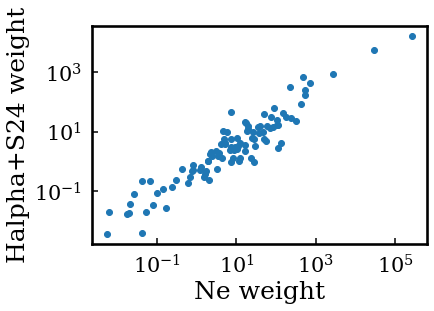

In [61]:
plt.figure()
total = 1/df.sf_Ne_unc**2 + 1/df.sf_Halpha_S24_unc**2
plt.plot(1/df.sf_Ne_unc**2, 1/df.sf_Halpha_S24_unc**2, 'o')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Ne weight')
plt.ylabel('Halpha+S24 weight')

remain num of df: 102.00
3.407754860732038e+58


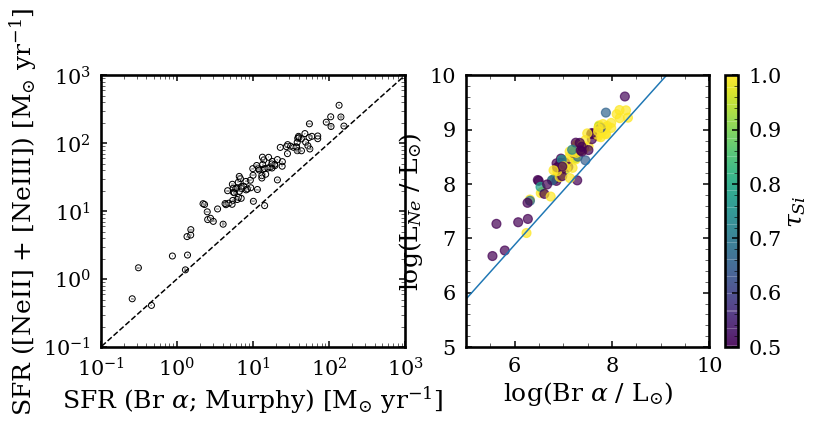

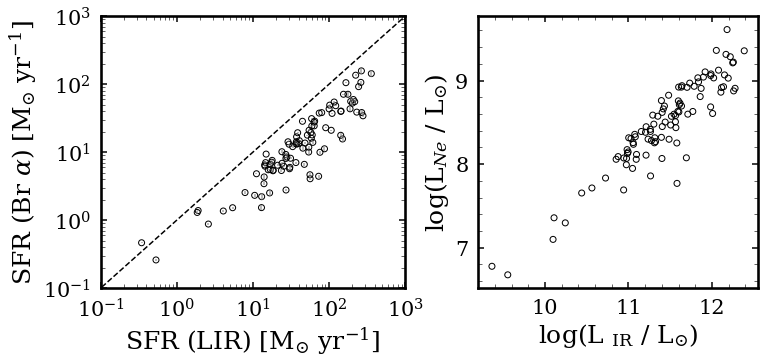

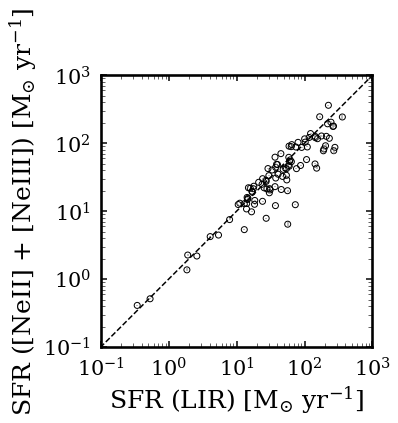

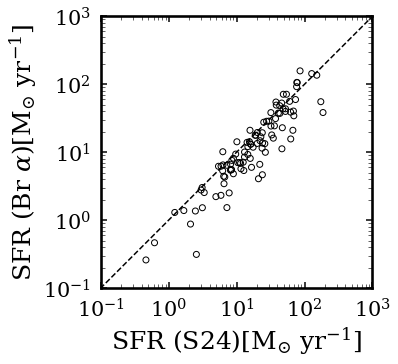

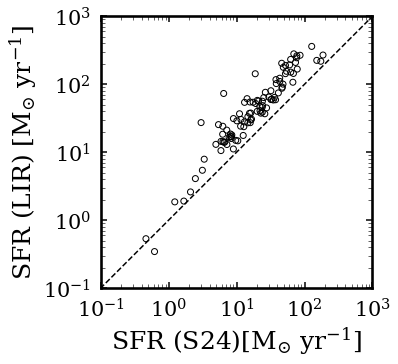

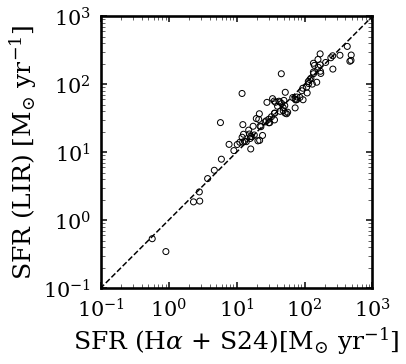

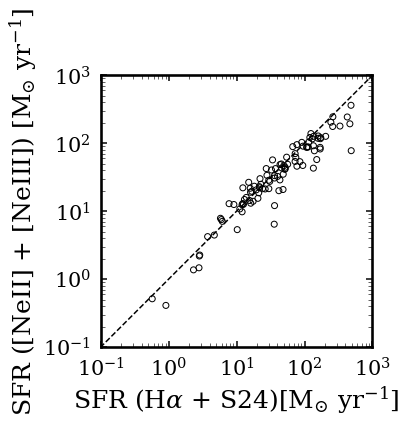

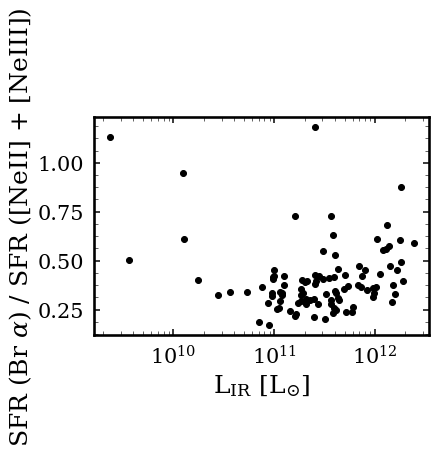

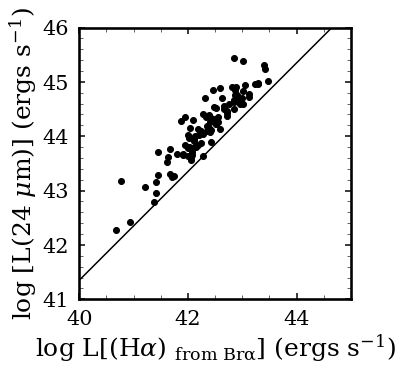

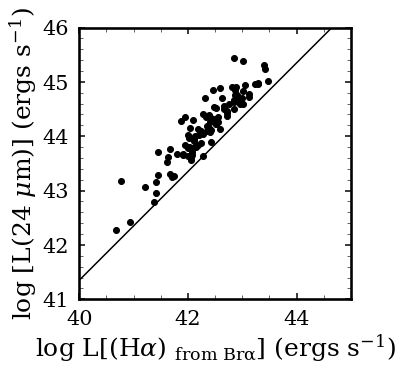

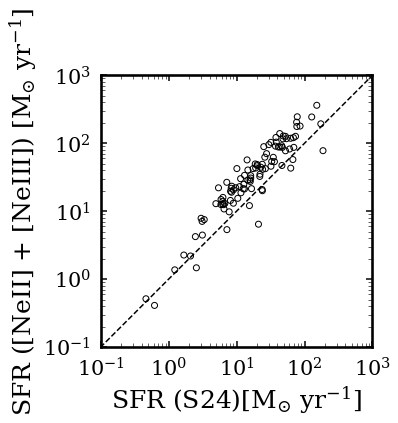

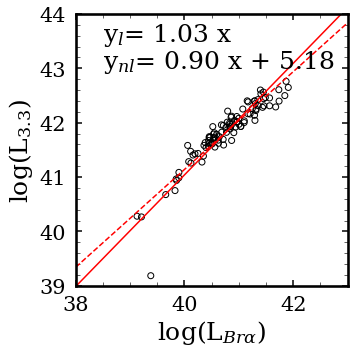

In [332]:
from astropy import constants as c

# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

# Chose mode "mx", "oc" or "sc" # mixed, obscured continuum, and screen
mode = 'oc'
if mode == 'sc':
    df = sc
if mode == 'oc':
    df = oc
if mode == 'mx':
    df = mx
    

# Read and non detection:
# cutoff_sn = 3
# fs_rd = fs[fs.L_Br_alpha/fs.L_Br_alpha_unc >= cutoff_sn] # real-detection
# fs_nd = fs[fs.L_Br_alpha/fs.L_Br_alpha_unc < cutoff_sn] # non-detection

plt.close(1) 
fig = plt.figure(num=1, figsize=(12,5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#for df in [fs_rd]:#, fs_nd]:    
# Only work on stars that have all the detection:
df = df[(df.L_NeII/df.L_NeII_unc > 3) & (df.L_NeIII/df.L_NeIII_unc > 3) & (df.L_Br_alpha/df.L_Br_alpha_unc > 2.990)].copy()
# Put df.L_Br_alpha/df.L_Br_alpha_unc > 2.990 in order to satisfy 3370038, which has a weak Br alpha in fp geometry but survives the cut in fs
print("remain num of df: {:.2f}".format(len(df)))



#if df.equals(fs_rd):
ax.scatter(df.sf_Bra, df.sf_Ne, marker='o', edgecolors='k', facecolors='none')
ax.errorbar(df.sf_Bra, df.sf_Ne, yerr=[df.sf_Ne_unc, df.sf_Ne_unc], xerr=[df.sf_Bra_unc, df.sf_Bra_unc],
            fmt='none', capsize=0, ecolor='gray', alpha=0.7, zorder=1)
#ax.errorbar(sf_Ne, sf_Bra, , fmt='none', capsize=0, ecolor='gray', alpha=0.7, zorder=1)

#if df.equals(fs_nd):
#    ax.scatter(sf_Ne, 3*sf_Bra_unc, marker='v', s=60, edgecolors='k', facecolors='none')
        #ax.scatter(sf_Ne, sf_Bra, marker='o', edgecolors='k', facecolors='none')
        #for i in range(len(df)):
        #    ax.scatter(sf_Ne.iloc[i], 3*df.L_Br_alpha_unc.iloc[i], marker='<')
            #ax.annotate('asdf', xy=(10, 1), xytext=(300, 1), arrowprops=dict(facecolor='black', shrink=0.05))
            #ax.arrow(200, 400, -50, 0, length_includes_head=True, head_width=500, head_length=20)
            #ax.arrow(sf_Ne[i], 3*df.L_Br_alpha_unc.iloc[i], -50, 0, length_includes_head=True)

ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_ylabel(r'SFR ([NeII] + [NeIII]) [M$_{\odot}$ yr$^{-1}$]')

if sf == 'Murata':
    ax.set_xlabel(r'SFR (Br $\alpha$; Murata) [M$_{\odot}$ yr$^{-1}$]')
if sf == 'Murphy':
    ax.set_xlabel(r'SFR (Br $\alpha$; Murphy) [M$_{\odot}$ yr$^{-1}$]')
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
#ax.set_xlim([-1, 5])
#ax.set_ylim([-1, 5])
#fig.gca().set_aspect('equal')

# ---------------------------------------------
cm = plt.cm.get_cmap('viridis')#('RdBu_r')##
color = df.tau_Si


# ax2.scatter(np.log10((df.L_NeII + df.L_NeIII)/c.L_sun.to('erg/s').value), 
#             np.log10(df.L_Br_alpha/c.L_sun.to('erg/s').value), 
#             marker='o', edgecolors='k', facecolors='none')

sc4 = ax2.scatter(np.log10(df.L_Br_alpha/c.L_sun.to('erg/s').value),
                  np.log10((df.L_NeII + df.L_NeIII)/c.L_sun.to('erg/s').value), 
                  c=color,#tau_Si,#df.tau_Si.values, #facecolors="None", edgecolors=c, 
                  s=80, cmap=cm, linewidth=1.2, 
                  vmin=0.5, vmax=1., alpha=0.7, zorder=2)

cbar = fig.colorbar(sc4)
cbar.ax.set_ylabel(r'$\tau _{Si}$')

ax2.set_xlim(5, 10)
ax2.set_ylim(5, 10)
ax2.set_xlabel(r'log(Br $\alpha$ / L$_{\odot}$)')
ax2.set_ylabel(r'log(L$_{Ne}$ / L$_{\odot}$)')
ax2.plot([-1, 10], [-1+0.881, 10+0.881])

#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/star_formation.pdf')
# ====================================================

fig = plt.figure(num=2, figsize=(12,5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.scatter(df.sf_LIR, df.sf_Bra, marker='o', edgecolors='k', facecolors='none')
ax.errorbar(df.sf_LIR, df.sf_Bra, yerr=[df.sf_Bra_unc, df.sf_Bra_unc],
            fmt='none', capsize=0, ecolor='gray', alpha=0.7, zorder=1)

ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xlabel(r'SFR (LIR) [M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR (Br $\alpha$) [M$_{\odot}$ yr$^{-1}$]')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
fig.gca().set_aspect('equal')
# ---------------------------------------
ax2.scatter(df.log_LIR, 
            np.log10((df.L_NeII + df.L_NeIII)/c.L_sun.to('erg/s').value), 
            marker='o', edgecolors='k', facecolors='none')
ax2.set_xlabel(r'log(L $_\mathrm{{IR}}$ / L$_{\odot}$)')
ax2.set_ylabel(r'log(L$_{Ne}$ / L$_{\odot}$)')

# ====================================================

fig = plt.figure(num=3, figsize=(5,5))
ax = fig.add_subplot(111)

ax.scatter(df.sf_LIR, df.sf_Ne, marker='o', edgecolors='k', facecolors='none')
ax.errorbar(df.sf_LIR, df.sf_Ne, yerr=[df.sf_Ne_unc, df.sf_Ne_unc],
            fmt='none', capsize=0, ecolor='gray', alpha=0.7, zorder=1)

ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_ylabel(r'SFR ([NeII] + [NeIII]) [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlabel(r'SFR (LIR) [M$_{\odot}$ yr$^{-1}$]')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
fig.gca().set_aspect('equal')
# ====================================================
fig = plt.figure(num=4, figsize=(5,5))
# MIPS_synphot_pd.read_table('/Users/thomaslai/Documents/astro/PAH/AKARIarchive/MIPS_synphot.txt',
#                                delim_whitespace=True, names=['irc_id','S24'], 
#                                dtype={'irc_id':str})

# df = df.merge(MIPS_synphot_df, how='left', left_on=['irc_id'], right_on=['irc_id'])

# MIPS 24 eff wavelength: 23.68 microns
nu = c.c / (23.68*u.micron.to('m'))
nu = nu.value
#df['L_S24'] = 4 * np.pi * cosmo.luminosity_distance(df.z).to(u.cm)**2 * df.S24 * 1E-26 * nu

df['sf_S24'] = 5.58E-36 * df.L_S24**0.826 # Murphy2011
print(max(nu*df.L_S24))

df['sf_Halpha_S24'] = 5.37E-42 * (df.L_Br_alpha*1/0.02778 + 0.031*df.L_S24)
df['sf_Halpha_S24_unc'] = 5.37E-42 * (df.L_Br_alpha_unc*1/0.02778)

# if mode == 'fs':
#     df.to_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fs_SFR.pkl")
# if mode == 'fp':
#     df.to_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fp_SFR.pkl")
# if mode == 'mx':
#     df.to_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")
    
ax = fig.add_subplot(111)
ax.scatter(df.sf_S24, df.sf_Bra, marker='o', edgecolors='k', facecolors='none')
#ax.errorbar(10**df.log_lir, sf_Bra/sf_Ne, fmt='o', color='k')
ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'SFR (S24)[M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR (Br $\alpha$)[M$_{\odot}$ yr$^{-1}$]')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
fig.gca().set_aspect('equal')
# ====================================================
fig = plt.figure(num=5, figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(df.sf_S24, df.sf_LIR, marker='o', edgecolors='k', facecolors='none')
ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'SFR (S24)[M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR (LIR) [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
fig.gca().set_aspect('equal')
# ====================================================
# SFR_mix (from H alpha & S24)
fig = plt.figure(num=6, figsize=(5,5))
ax = fig.add_subplot(111)

ax.scatter(df.sf_Halpha_S24, df.sf_LIR, marker='o', edgecolors='k', facecolors='none')
ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'SFR (H$\alpha$ + S24)[M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR (LIR) [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
fig.gca().set_aspect('equal')
# ====================================================
fig = plt.figure(num=7, figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(df.sf_Halpha_S24, df.sf_Ne, marker='o', edgecolors='k', facecolors='none')
ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'SFR (H$\alpha$ + S24)[M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR ([NeII] + [NeIII]) [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
fig.gca().set_aspect('equal')
# ====================================================
fig = plt.figure(num=71, figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(df.sf_S24, df.sf_Ne, marker='o', edgecolors='k', facecolors='none')
ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'SFR (S24)[M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR ([NeII] + [NeIII]) [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
fig.gca().set_aspect('equal')
# ====================================================
fig = plt.figure(num=8, figsize=(6,4))

ax = fig.add_subplot(111)
ax.errorbar(10**df.log_LIR, df.sf_Bra/df.sf_Ne, fmt='o', color='k')
ax.set_xscale('log')
ax.set_xlabel(r'$\mathrm{L_{IR} \ [L_{\odot}]}$')
ax.set_ylabel(r'SFR (Br $\alpha$) / SFR ([NeII] + [NeIII])')
# ====================================================

# plt.figure()
# df['r'] = df.L_Br_alpha / df.L_IR
# # b = df.dropna(subset=['r'])
# # plt.hist(b.r)
# # print(np.mean(b.r))
# #plt.plot(df.log_lir, df.r,'o')
# plt.plot(df.log_lir, np.log10(sf_Bra/sf_LIR), 'o')
# #plt.yscale('log')
# plt.ylim(-1.5,1)
# ====================================================
from astropy.modeling import models
from astropy.modeling import models, fitting

# For the regression line goes to 0: 
# Our model is y = a * x, so things are quite simple, in this case...
# x needs to be a column vector instead of a 1D vector for this, however.
# x_fit = x[:,np.newaxis]
# y_fit = y
# slope, resid, rank, sigma = np.linalg.lstsq(x_fit, y_fit)

x = np.log10(df.L_Br_alpha)
y = np.log10(df.L_f33)

df_tmp = pd.DataFrame({'x':x, 'y':y})

df1 = df_tmp[~df_tmp.isin([np.nan, np.inf, -np.inf]).any(1)]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(x, y, marker='o', edgecolor='k', facecolor='none')

for mode in ['linear', 'nonlinear']:
    l_init = models.Linear1D(slope=1, intercept=0)
    fit_l = fitting.LevMarLSQFitter()
    xx = [38, 43]
    if mode == 'linear':
        l_init.intercept.fixed = True
        l = fit_l(l_init, df1.x, df1.y)
        ax.plot(xx, l.slope*np.array(xx) + l.intercept, 'r')
        ax.annotate(r'y$_{l}$' + '= {:.2f} x'.format(l.slope.value), xy=(0.1, 0.9), xycoords='axes fraction')  
    else:
        l = fit_l(l_init, df1.x, df1.y)
        ax.plot(xx, l.slope*np.array(xx) + l.intercept, '--r')
        ax.annotate(r'y$_{nl}$' + '= {:.2f} x + {:.2f}'.format(l.slope.value, l.intercept.value), xy=(0.1, 0.8), xycoords='axes fraction') 
  
        
ax.set_xlabel(r'log(L$_{Br \alpha}$)')
ax.set_ylabel(r'log(L$_{3.3}$)')
ax.set_xlim(38, 43)
ax.set_ylim(39, 44)

fig.gca().set_aspect('equal')

fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/pah33andBralpha.pdf')
# =====================================
x = np.linspace(40, 46, 6)
y = x + 1.35

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.plot(np.log10(df.L_Br_alpha * 100/2.778), np.log10(df.L_S24), 'ko')
ax.plot(x, y, 'k')


ax.set_xlabel(r'log L[(H$\alpha$) $\mathrm{_{from \ Br \alpha}}$] (ergs s$^{-1}$)')
ax.set_ylabel(r'log [L(24 $\mu$m)] (ergs s$^{-1}$)')
ax.set_xlim(40, 45)
ax.set_ylim(41, 46)

fig.gca().set_aspect('equal')
# ------------------------
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.plot(np.log10(df.L_Br_alpha * 100/2.778), np.log10(df.L_S24), 'ko')
ax.plot(x, y, 'k')


ax.set_xlabel(r'log L[(H$\alpha$) $\mathrm{_{from \ Br \alpha}}$] (ergs s$^{-1}$)')
ax.set_ylabel(r'log [L(24 $\mu$m)] (ergs s$^{-1}$)')
ax.set_xlim(40, 45)
ax.set_ylim(41, 46)

fig.gca().set_aspect('equal')
# ------------------------



conti(2.7)/S24 > 0.1 were removed from the input DataFrame 
conti(2.7)/S24 > 0.1 were removed from the input DataFrame 
conti(2.7)/S24 > 0.1 were removed from the input DataFrame 


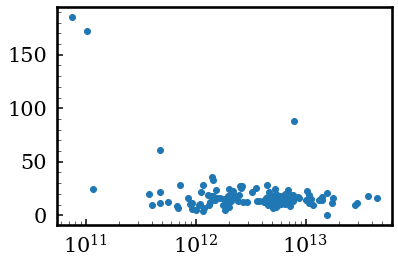

In [17]:
# Read in data
sc_rd, sc_nd, mx_rd, mx_nd, oc_rd, oc_nd = tl.read_geometry_csv(snr_cut=True)

mx = pd.concat([mx_rd, mx_nd], ignore_index=True)
oc = pd.concat([oc_rd, oc_nd], ignore_index=True)
sc = pd.concat([sc_rd, sc_nd], ignore_index=True)

plt.figure()
#plt.plot(mx.Br_alpha_strength, mx.f33/mx.Br_alpha_strength, 'o')
plt.plot(mx_rd.Br_alpha_strength, mx_rd.f33/mx_rd.Br_alpha_strength, 'o')

plt.xscale('log')

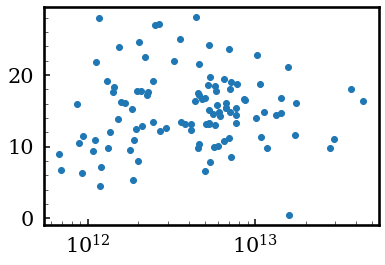

In [30]:
df = mx_rd[mx_rd.Br_alpha_strength > 3*mx_rd.Br_alpha_strength_unc]

plt.figure()
plt.plot(df.Br_alpha_strength, df.f33/df.Br_alpha_strength, 'o')

plt.xscale('log')
# a = mx_rd[mx_rd.f33/mx_rd.Br_alpha_strength > 100]
# a
#raise


In [28]:
df

Empty DataFrame
Columns: [Br_alpha_strength, Br_alpha_strength_unc, GOALS_target, NeIII_strength, NeIII_strength_unc, NeII_strength, NeII_strength_unc, akari_color, conti27, conti43, dfwhm12, dfwhm6, f113, f113_unc, f17, f17_unc, f33, f33_fwhm, f33_unc, f33ew, f34, f347, f347_fwhm, f347_unc, f34_fwhm, f34_unc, f62, f62_unc, f62ew, f77, f77_unc, f83, f83_unc, f86, f86_unc, fwhm_H2O, hot_grains, irc_id, log_LIR, mirclass, pah62_eqw_err_ideos, pah62_eqw_ideos, phase, snr_at33, target, tau_H2O, tau_Si, tau_Si_ideos, tot_pah, tot_pah_unc, vsg, z, S24, S24_snr, S24_unc, S24_color, L_f33, L_f34, L_f347, L_f62, L_f77, L_f83, L_f86, L_f113, L_f17, L_tot_pah, L_NeII, L_NeII_unc, L_NeIII, L_NeIII_unc, L_Br_alpha, L_Br_alpha_unc, L_S24, L_S24_unc, L_IR, nsum, nsum_int, conti27_to_S24]
Index: []

[0 rows x 78 columns]

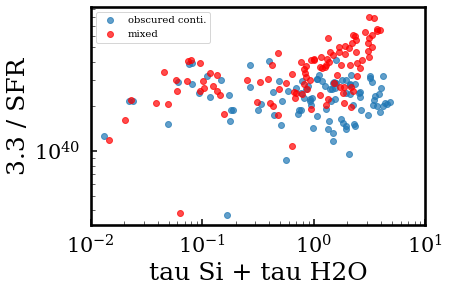

In [12]:


plt.figure()
#plt.plot(fs.tau_Si + fs.tau_H2O, fs.L_f33/fs.sf, 'ro', alpha=0.7)
plt.plot(oc.tau_Si + oc.tau_H2O, oc.L_f33/oc.sf_Ne, 'o', alpha=0.7, label='obscured conti.')
plt.plot(mx.tau_Si + mx.tau_H2O, mx.L_f33/mx.sf_Ne, 'ro', alpha=0.7, label='mixed')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('tau Si + tau H2O')
plt.ylabel('3.3 / SFR')
plt.xlim(1E-2, 10)

plt.legend(loc=2, fontsize=10)

In [385]:
[np.percentile(fs.tau_Si + fs.tau_H2O, i) for i in [0, 25, 50, 75, 100]]

[0.0,
 0.27653044046650832,
 0.61902807687817529,
 1.099548069970453,
 2.0266009955430029]

correlation coef: 0.86
std: 0.21 dex
std: 0.17 dex
std: 0.19 dex


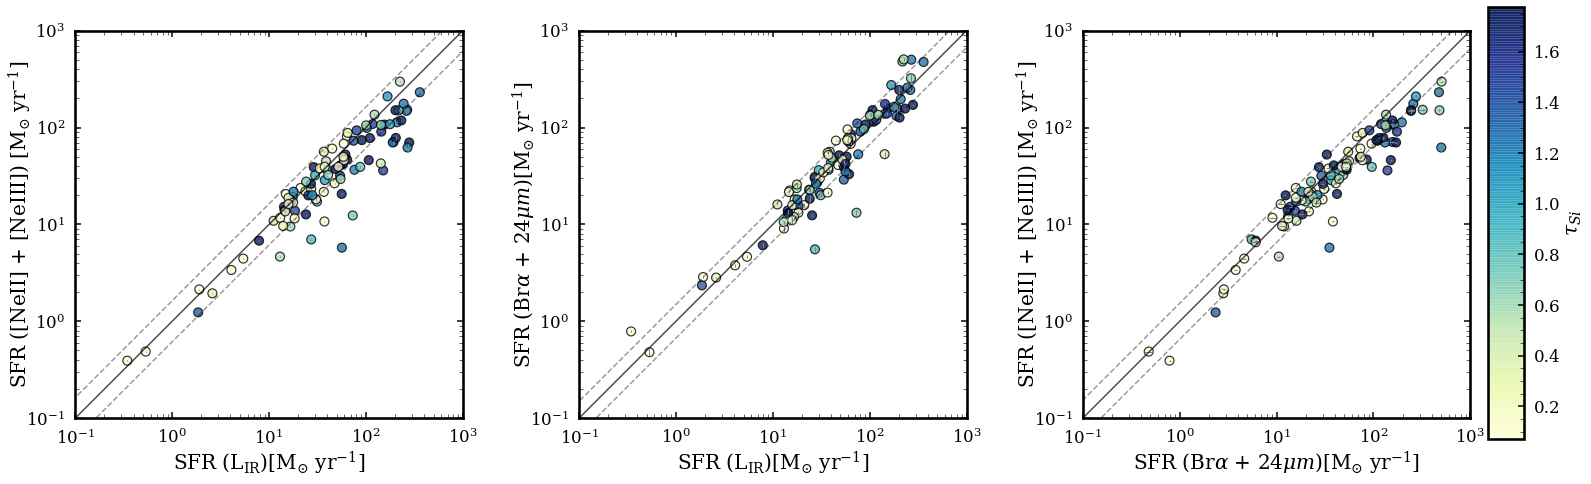

In [22]:
# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

mode = 'oc'
if mode == 'mx':
    df = mx
if mode == 'oc':
    df = oc

print("correlation coef: {:.2f}".format(np.corrcoef(df.sf_Halpha_S24, df.sf_Ne)[0,1]))
np.std(df.sf_Halpha_S24/df.sf_Ne)

# fig = plt.figure(num=7, figsize=(10,10))
# ax = fig.add_subplot(111)

fig = plt.figure(figsize=(25, 8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

df['color'] = df.tau_Si 

#df = df.dropna()



# model = models.Linear1D(slope=1, intercept=0, fixed={'slope':True, 'intercept':True})    
# fitter = fitting.LinearLSQFitter()
# best_fit = fitter(model, df.sf_LIR, df.sf_Ne)
# print(best_fit)

sc1 = ax1.scatter(df.sf_LIR, df.sf_Ne, c=df.color,
         s=80, cmap='YlGnBu', linewidth=1.2,  #'RdGy_r'
         vmin=np.percentile(df.color,20), vmax=np.percentile(df.color,80), alpha=0.8, zorder=2, edgecolors='k')

std1 = np.std(np.log10(df.sf_Ne/df.sf_LIR))
print("std: {:.2f} dex".format(std1))

ax1.errorbar(df.sf_LIR, df.sf_Ne, yerr=df.sf_Ne_unc.values,fmt='none', ecolor='gray', linewidth=1)
ax1.set_xlabel(r'SFR (L$_\mathrm{IR}$)[M$_{\odot}$ yr$^{-1}$]', labelpad=2)
ax1.set_ylabel(r'SFR ([NeII] + [NeIII]) [M$_{\odot}$ yr$^{-1}$]', labelpad=-8)



sc2 = ax2.scatter(df.sf_LIR, df.sf_Halpha_S24, c=df.color,
         s=80, cmap='YlGnBu', linewidth=1.2,  #'RdGy_r'
         vmin=np.percentile(df.color,20), vmax=np.percentile(df.color,80), alpha=0.8, zorder=2, edgecolors='k')

std2 = np.std(np.log10(df.sf_Halpha_S24/df.sf_LIR))
print("std: {:.2f} dex".format(std2))

ax2.errorbar(df.sf_LIR, df.sf_Halpha_S24, yerr=df.sf_Halpha_S24_unc.values,fmt='none', ecolor='gray', linewidth=1)
ax2.set_xlabel(r'SFR (L$_\mathrm{IR}$)[M$_{\odot}$ yr$^{-1}$]', labelpad=2)
ax2.set_ylabel(r'SFR (Br$\alpha$ + 24$\mu m$)[M$_{\odot}$ yr$^{-1}$]', labelpad=-8)


sc3 = ax3.scatter(df.sf_Halpha_S24, df.sf_Ne, c=df.color,
         s=80, cmap='YlGnBu', linewidth=1.2,  #'RdGy_r'
         vmin=np.percentile(df.color,20), vmax=np.percentile(df.color,80), alpha=0.8, zorder=2, edgecolors='k')

std3 = np.std(np.log10(df.sf_Ne/df.sf_Halpha_S24))
print("std: {:.2f} dex".format(std3))

ax3.errorbar(df.sf_Halpha_S24, df.sf_Ne, xerr=df.sf_Halpha_S24_unc.values, yerr=df.sf_Ne_unc.values,fmt='none', ecolor='gray', linewidth=1)
ax3.set_xlabel(r'SFR (Br$\alpha$ + 24$\mu m$)[M$_{\odot}$ yr$^{-1}$]', labelpad=2)
ax3.set_ylabel(r'SFR ([NeII] + [NeIII]) [M$_{\odot}$ yr$^{-1}$]', labelpad=-8)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.75])
cbar = fig.colorbar(sc3, cax=cbar_ax, shrink=0.9)
cbar.ax.set_ylabel(r'$\tau _{Si}$')

#cbar = fig.colorbar(sc1, cax=cbar_ax, ticks=np.linspace(15, 95, 5))


#ax.scatter(df.sf_Halpha_S24, df.sf_Ne, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)

for ax, std in zip([ax1, ax2, ax3], [std1, std2, std3]):
    ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='-', alpha=0.7)
    ax.plot([0.01, 1000],[10**(np.log10(0.01)-std), 10**(np.log10(1000)-std)], color='k', linestyle='--', alpha=0.4)
    ax.plot([0.01, 1000],[10**(np.log10(0.01)+std), 10**(np.log10(1000)+std)], color='k', linestyle='--', alpha=0.4)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.1, 1000])
    ax.set_ylim([0.1, 1000])
    ax.set_aspect('equal', 'box')
    
fig.subplots_adjust(wspace=0.3)
#plt.tight_layout()
#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/SFRI_'+mode+'.pdf')

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept    
    ------------------ -----------------
    0.8174857122694733 5.053885529432729
std: 0.25 dex
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    0.9340957477191049 2.6011224467158973
std: 0.17 dex
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept    
    ------------------ -----------------
    0.7905133653188189 7.967999081153703
std: 0.25 dex


Text(0, 0.5, '$\\tau _{Si}$')

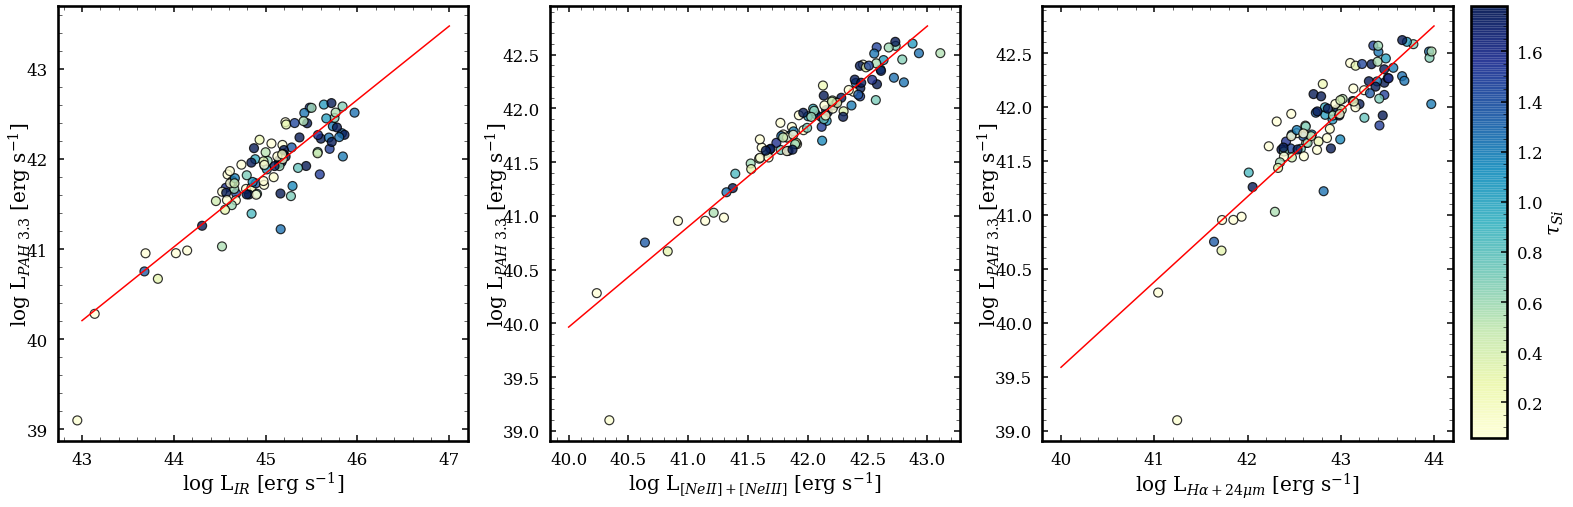

In [21]:
matplotlib.rcParams.update({'font.size': 20})
from astropy.modeling import models, fitting
#plt.rcParams["xtick.top"] = True


# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

mode = 'oc'
if mode == 'mx':
    df = mx
if mode == 'oc':
    df = oc
fig = plt.figure(figsize=(25, 8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)


df['color'] = df.tau_Si 

df = df.dropna(subset=['L_IR'])

model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(df.L_IR), np.log10(df.L_f33))
print(best_fit)

std1 = np.std(np.log10(df.L_f33) - best_fit(np.log10(df.L_IR)))
print("std: {:.2f} dex".format(std1))

sc1 = ax1.scatter(np.log10(df.L_IR), np.log10(df.L_f33), c=df.color,
         s=80, cmap='YlGnBu', linewidth=1.2,  #'RdGy_r'
         vmin=np.percentile(df.color,20), vmax=np.percentile(df.color,80), alpha=0.8, zorder=2, edgecolors='k')

ax1.plot(np.arange(43, 48), best_fit(np.arange(43, 48)), 'r')

# ax1.errorbar(df.sf_LIR, df.sf_Ne, yerr=df.sf_Ne_unc.values,fmt='none', ecolor='gray', linewidth=1)
ax1.set_xlabel(r'log L$_{IR}$ [erg s$^{-1}$]', labelpad=2)
ax1.set_ylabel(r'log L$_{PAH \ 3.3}$ [erg s$^{-1}$]', labelpad=-8)

# ------------------------------------
model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(df.L_Ne_comb), np.log10(df.L_f33))
print(best_fit)

std2 = np.std(np.log10(df.L_f33) - best_fit(np.log10(df.L_Ne_comb)))
print("std: {:.2f} dex".format(std2))

sc2 = ax2.scatter(np.log10(df.L_Ne_comb), np.log10(df.L_f33), c=df.color,
         s=80, cmap='YlGnBu', linewidth=1.2,  #'RdGy_r'
         vmin=np.percentile(df.color,20), vmax=np.percentile(df.color,80), alpha=0.8, zorder=2, edgecolors='k')
ax2.plot(np.arange(40, 44), best_fit(np.arange(40, 44)), 'r')

# ax2.errorbar(df.sf_LIR, df.sf_Halpha_S24, yerr=df.sf_Halpha_S24_unc.values,fmt='none', ecolor='gray', linewidth=1)
ax2.set_xlabel(r'log L$_{[NeII]+[NeIII]}$ [erg s$^{-1}$]', labelpad=2)
ax2.set_ylabel(r'log L$_{PAH \ 3.3}$ [erg s$^{-1}$]', labelpad=-8)


# ------------------------------------
model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(df.L_Br_alpha*100/2.778 + 0.031*df.L_S24), np.log10(df.L_f33))
print(best_fit)

std3 = np.std(np.log10(df.L_f33) - best_fit(np.log10(df.L_Br_alpha*100/2.778 + 0.031*df.L_S24)))
print("std: {:.2f} dex".format(std3))

sc3 = ax3.scatter(np.log10(df.L_Br_alpha*100/2.778 + 0.031*df.L_S24), np.log10(df.L_f33), c=df.color,
         s=80, cmap='YlGnBu', linewidth=1.2,  #'RdGy_r'
         vmin=np.percentile(df.color,20), vmax=np.percentile(df.color,80), alpha=0.8, zorder=2, edgecolors='k')
ax3.plot(np.arange(40, 45), best_fit(np.arange(40, 45)), 'r')

# ax3.errorbar(df.sf_Halpha_S24, df.sf_Ne, xerr=df.sf_Halpha_S24_unc.values, yerr=df.sf_Ne_unc.values,fmt='none', ecolor='gray', linewidth=1)
ax3.set_xlabel(r'log L$_{H\alpha+24 \mu m}$ [erg s$^{-1}$]', labelpad=2)
ax3.set_ylabel(r'log L$_{PAH \ 3.3}$ [erg s$^{-1}$]', labelpad=-8)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.75])
cbar = fig.colorbar(sc3, cax=cbar_ax, shrink=0.9)
cbar.ax.set_ylabel(r'$\tau _{Si}$')

#for ax in [ax1, ax2, ax3]:
#     ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='-', alpha=0.7)
#     ax.plot([0.01, 1000],[0.01/2,1000/2], color='k', linestyle='--', alpha=0.4)
#     ax.plot([0.01, 1000],[0.01*2,1000*2], color='k', linestyle='--', alpha=0.4)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
#     ax.set_xlim([0.1, 1000])
#     ax.set_ylim([0.1, 1000])
    #ax.set_aspect('equal', 'box')

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         slope            intercept     
    ---------------- -------------------
    1.08681274176101 -0.7783438615498398
std = 0.44
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept    
    ------------------ -----------------
    0.0758590318707695 6.290524036857292
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           slope             intercept    
    -------------------- -----------------
    -0.05977062969173822 7.272063615906978
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    slope     intercept    
    ----- -----------------
      0.0 6.807714150201297


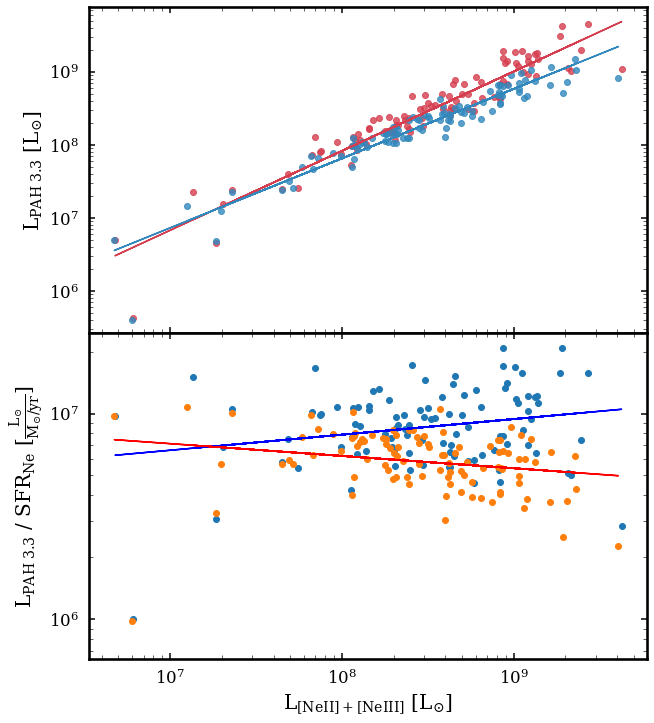

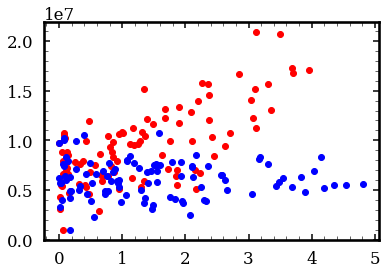

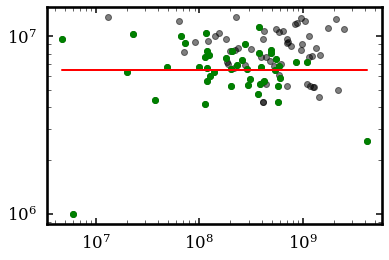

In [166]:
from bokeh.palettes import Spectral
from astropy.modeling import models, fitting

Spectral_r = Spectral[11][-2]  
Spectral_b = Spectral[11][1] 

# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

# mode = 'mx'
# if mode == 'mx':
#     df = mx
# if mode == 'oc':
#     df = oc

L_sun = const.L_sun.to('erg/s').value  

model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(mx.L_Ne_comb/L_sun), np.log10(mx.L_f33/L_sun))#, weights=1.0/k_mag_err**2)
print(best_fit)

std = np.std(df.L_f33/L_sun / 10**best_fit(np.log10(df.L_Ne_comb/L_sun)))
print("std = {:.2f}".format(std))

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(10, 12))
ax1.scatter(df.L_Ne_comb/L_sun, df.L_f33/L_sun, edgecolor=Spectral_r, facecolor=Spectral_r, alpha=0.8)

ax1.plot(df.L_Ne_comb/L_sun, 10**best_fit(np.log10(df.L_Ne_comb/L_sun)), color=Spectral_r)

model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(oc.L_Ne_comb/L_sun), np.log10(oc.L_f33/L_sun))#, weights=1.0/k_mag_err**2)

ax1.scatter(oc.L_Ne_comb/L_sun, oc.L_f33/L_sun, edgecolor=Spectral_b, facecolor=Spectral_b, alpha=0.8)
ax1.plot(oc.L_Ne_comb/L_sun, 10**best_fit(np.log10(oc.L_Ne_comb/L_sun)), color=Spectral_b)

#ax1.scatter(np.log10(df.L_Ne_comb), np.log10(df.L_f33))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'L$_\mathrm{PAH \ 3.3}$ [L$_{\odot}$]')

# ---------------------------------------------------------------------

model = models.Linear1D()#slope=0, fixed={'slope':True})    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(df.L_Ne_comb/L_sun), np.log10(df.L_f33/L_sun / df.sf_Ne))
print(best_fit)

ax2.scatter(df.L_Ne_comb/L_sun, df.L_f33/L_sun / df.sf_Ne)

ax2.plot(df.L_Ne_comb/L_sun, 10**best_fit(np.log10(df.L_Ne_comb/L_sun)), 'b')

model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(oc.L_Ne_comb/L_sun), np.log10(oc.L_f33/L_sun / oc.sf_Ne))
print(best_fit)

ax2.scatter(oc.L_Ne_comb/L_sun, oc.L_f33/L_sun / oc.sf_Ne)
ax2.plot(oc.L_Ne_comb/L_sun, 10**best_fit(np.log10(oc.L_Ne_comb/L_sun)), 'r')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'L$_\mathrm{[NeII]+[NeIII]}$ [L$_{\odot}$]')
ax2.set_ylabel(r'L$\mathrm{_{PAH \ 3.3}}$ / SFR$_\mathrm{Ne}$ [$\mathrm{\frac{L_{\odot}}{M_{\odot}/yr}}$]')
plt.subplots_adjust(hspace=0.0)


mx['sf_pah33'] = 1.47E-7 * mx.L_f33/L_sun
oc['sf_pah33'] = 1.47E-7 * oc.L_f33/L_sun


plt.figure()
plt.plot(mx.tau_Si+mx.tau_H2O, mx.L_f33/L_sun/mx.sf_Ne, 'ro')
plt.plot(oc.tau_Si+oc.tau_H2O, oc.L_f33/L_sun/oc.sf_Ne, 'bo')
# ---------------------------------------------------------------------

comb = pd.DataFrame({'x':np.mean([mx.L_Ne_comb, oc.L_Ne_comb], axis=0)/L_sun,
                     'y':np.mean([mx.L_f33/mx.sf_Ne, oc.L_f33/oc.sf_Ne], axis=0)/L_sun,         
                     'tau_Si':np.mean([mx.tau_Si, oc.tau_Si], axis=0),
                     'tau_H2O':np.mean([mx.tau_H2O, oc.tau_H2O], axis=0),
                    })

no_att = comb[(comb.tau_Si + comb.tau_H2O) < 1]

model = models.Linear1D(slope=0, fixed={'slope':True})    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(no_att.x), np.log10(no_att.y))
print(best_fit)



plt.figure()
plt.plot(comb.x, comb.y, 'ko', alpha=0.5)
plt.plot(no_att.x, no_att.y ,'go')
plt.plot(comb.x, 10**best_fit(np.log10(comb.x)), 'r')
plt.xscale('log')
plt.yscale('log')

In [ ]:
matplotlib.rcParams.update({'font.size': 30})

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope             intercept      
    ------------------ --------------------
    1.0427091121266483 -0.39897777004333784
std (mx)= 0.41
std (oc)= 0.31
43
41
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    slope     intercept    
    ----- -----------------
      0.0 7232734.034797029
obscured sources: 6.859302495327484
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    slope     intercept    
    ----- -----------------
      0.0 5850251.797520394
not obscured: 6.767174558718129
weighted std 1 sigma: 0.18 dex
Parameter('intercept', value=5850251.797520394)


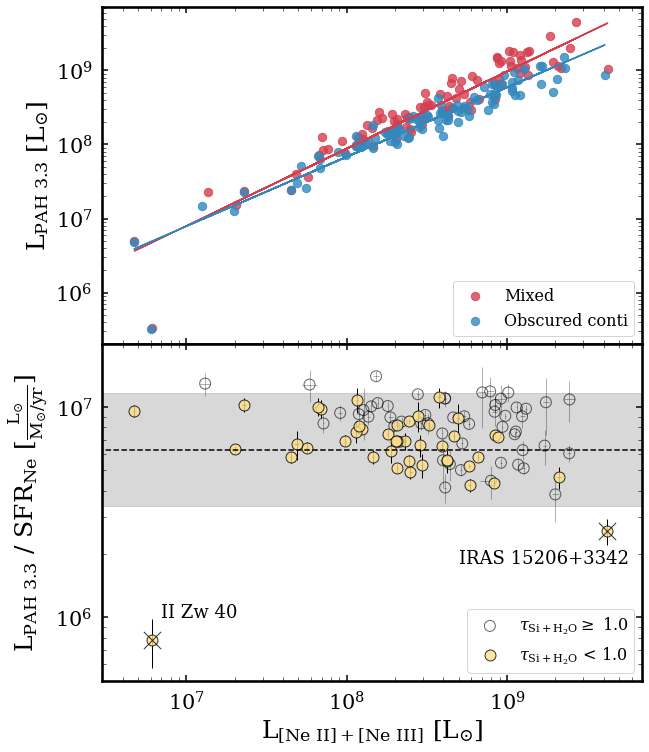

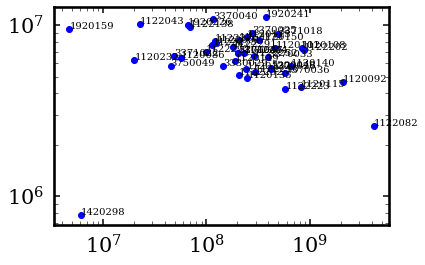

In [43]:

import math
from bokeh.palettes import Spectral
from bokeh.palettes import YlGnBu
from astropy.modeling import models, fitting

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

Spectral_r = Spectral[11][-2]  
Spectral_g = Spectral[11][2] 
Spectral_b = Spectral[11][1] 
Spectral_y = Spectral[11][6] 
YlGnBu_g = YlGnBu[9][5]
YlGnBu_y = YlGnBu[9][8]

# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

mode = 'mx'
if mode == 'mx':
    df = mx
if mode == 'oc':
    df = oc

L_sun = const.L_sun.to('erg/s').value  

model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(mx.L_Ne_comb/L_sun), np.log10(mx.L_f33/L_sun))#, weights=1.0/k_mag_err**2)
print(best_fit)

std1 = np.std(mx.L_f33/L_sun / 10**best_fit(np.log10(mx.L_Ne_comb/L_sun)))
print("std (mx)= {:.2f}".format(std1))

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(10, 12), sharex=True)
ax1.scatter(df.L_Ne_comb/L_sun, df.L_f33/L_sun, edgecolor=Spectral_r, facecolor=Spectral_r, alpha=0.8, s=70, label='Mixed')

ax1.plot(df.L_Ne_comb/L_sun, 10**best_fit(np.log10(df.L_Ne_comb/L_sun)), color=Spectral_r)


model = models.Linear1D()    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, np.log10(oc.L_Ne_comb/L_sun), np.log10(oc.L_f33/L_sun))#, weights=1.0/k_mag_err**2)

std2 = np.std(oc.L_f33/L_sun / 10**best_fit(np.log10(oc.L_Ne_comb/L_sun)))
print("std (oc)= {:.2f}".format(std2))

ax1.scatter(oc.L_Ne_comb/L_sun, oc.L_f33/L_sun, edgecolor=Spectral_b, facecolor=Spectral_b, alpha=0.8, s=70, label='Obscured conti')
ax1.plot(oc.L_Ne_comb/L_sun, 10**best_fit(np.log10(oc.L_Ne_comb/L_sun)), color=Spectral_b)
ax1.legend(loc=4, fontsize=16)

#ax1.scatter(np.log10(df.L_Ne_comb), np.log10(df.L_f33))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'L$_\mathrm{PAH \ 3.3}$ [L$_{\odot}$]')
ax1.set_xlim(3E6, 7E9)
# ---------------------------------------------------------------------

# Add L_f33_unc
mx['L_f33_unc'] = mx.L_f33 * mx.f33_unc/mx.f33
oc['L_f33_unc'] = oc.L_f33 * oc.f33_unc/oc.f33

# combine mx and oc
both = mx.merge(oc, how='inner', left_on=['irc_id'], right_on=['irc_id'], indicator=True, suffixes=('_mx', '_oc'))

# Deal with unc that is 0
# add a very small number in the weights - 0.0001 
comb = pd.DataFrame({'irc_id': both.irc_id,
                     'x': np.average([both.L_Ne_comb_mx, both.L_Ne_comb_oc], weights=[1/(both.L_Ne_comb_unc_mx+0.0001)**2, 1/(both.L_Ne_comb_unc_oc+0.0001)**2], axis=0)/L_sun,
                     'x_unc': np.sqrt(both.L_Ne_comb_unc_mx**2 + both.L_Ne_comb_unc_oc**2)/L_sun,
                     'y': np.average([both.L_f33_mx/both.sf_Ne_mx, both.L_f33_oc/both.sf_Ne_oc], axis=0)/L_sun,         
                     'y_unc': np.sqrt((both.L_f33_mx/both.sf_Ne_mx)**2 * ((both.L_f33_unc_mx/both.L_f33_mx)**2 + (both.sf_Ne_unc_mx/both.sf_Ne_mx)**2) + 
                                      (both.L_f33_oc/both.sf_Ne_oc)**2 * ((both.L_f33_unc_oc/both.L_f33_oc)**2 + (both.sf_Ne_unc_oc/both.sf_Ne_oc)**2))/L_sun,
                     'tau_Si': np.mean([both.tau_Si_mx, both.tau_Si_oc], axis=0),
                     'tau_H2O': np.mean([both.tau_H2O_mx, both.tau_H2O_oc], axis=0),
                    })

not_obsc = comb[(comb.tau_Si + comb.tau_H2O) < 1]
obsc = comb[(comb.tau_Si + comb.tau_H2O) >= 1]

print(len(not_obsc))
# exclude IIZw 40, IRAS 15206+3342, and NGC 3081 to do the linear fit
not_obsc_slc = not_obsc[(not_obsc.irc_id != '1420298') & (not_obsc.irc_id != '1122082') & (not_obsc.irc_id != '1120082')]
print(len(not_obsc_slc))

# For obscured sources
model = models.Linear1D(slope=0, fixed={'slope':True})    
fitter = fitting.LinearLSQFitter()
best_fit = fitter(model, obsc.x, obsc.y, weights=1.0/obsc.y_unc**2)
print(best_fit)
print("obscured sources: {}".format(np.log10(best_fit.intercept)))

# For not obscured sources
model = models.Linear1D(slope=0, fixed={'slope':True})    
fitter = fitting.LinearLSQFitter()
#best_fit = fitter(model, np.log10(not_obsc_slc.x), np.log10(not_obsc_slc.y), weights=1.0/not_obsc_slc.y_unc**2)

best_fit = fitter(model, not_obsc_slc.x, not_obsc_slc.y, weights=1.0/not_obsc_slc.y_unc**2)
print(best_fit)
print("not obscured: " + str(np.log10(best_fit.intercept)))

avg, std = weighted_avg_and_std(not_obsc_slc.y, weights=1.0/not_obsc_slc.y_unc**2)

std_dex = np.log10(avg+std)-np.log10(avg-std)
print("weighted std 1 sigma: {:.2f} dex".format(std_dex))

# std = np.std(np.log10(not_obsc_slc.y))
# print("std: {:.2f} dex".format(std))

#ax2.scatter(not_obsc_slc.x, not_obsc_slc.y, marker='x',s=200,zorder=5, color='r')

ax2.scatter(obsc.x, obsc.y, edgecolor='k', facecolor='none', s=120, alpha=0.6, label=r'$\tau_\mathrm{Si+H_{2}O} \geq$ 1.0')
ax2.errorbar(obsc.x, obsc.y, xerr=obsc.x_unc, yerr=obsc.y_unc, fmt='none', color='k', linewidth=1, zorder=1, label='_nolegend_', alpha=0.3)
ax2.scatter(not_obsc.x, not_obsc.y, edgecolor='k', facecolor=Spectral_y, s=120, label=r'$\tau_\mathrm{Si+H_{2}O}$ < 1.0', alpha=0.8, zorder=2)
ax2.errorbar(not_obsc.x, not_obsc.y, xerr=not_obsc.x_unc, yerr=not_obsc.y_unc, fmt='none', color='k', linewidth=1, zorder=1, label='_nolegend_')
print(best_fit.intercept)
#ax2.hlines(best_fit.intercept, xmin=1E6, xmax=1E10, linestyle='dashed', label='_nolegend_')
ax2.hlines(avg, xmin=1E6, xmax=1E10, linestyle='dashed', label='_nolegend_')
ax2.fill_between(10**np.arange(6, 11), y1=10**(np.log10(avg)-std_dex*1.5), y2=10**(np.log10(avg)+std_dex*1.5), alpha=0.3, color='gray', zorder=0)

#ax2.fill_between(10**np.arange(6, 11), y1=10**(-std+np.log10(best_fit.intercept)), y2=10**(std+np.log10(best_fit.intercept)), alpha=0.3, color='gray', zorder=0)

IIZw40 = not_obsc[not_obsc.irc_id == '1420298']
ax2.scatter(IIZw40.x, IIZw40.y, marker='x', s=300, color='k', zorder=3, label='_nolegend_', alpha=0.8, linewidth=1)
ax2.annotate('II Zw 40', xy=(7E6, 1E6), fontsize=18)  #, xytext=(0.6, 4E5),
            #arrowprops=dict(facecolor='black', shrink=0.02, width=1),
            #)

IRAS15206 = not_obsc[not_obsc.irc_id == '1122082'] 
ax2.scatter(IRAS15206.x, IRAS15206.y, marker='x', s=300, color='k', zorder=3, label='_nolegend_', alpha=0.8, linewidth=1)

ax2.annotate('IRAS 15206+3342', xy=(5E8, 1.8E6), fontsize=18)  #, xytext=(0.6, 4E5),
            #arrowprops=dict(facecolor='black', shrink=0.02, width=1),
            #)
    
# ax2.annotate('NGC 612', xy=(2E8, 1.3E7), fontsize=18)  #, xytext=(0.6, 4E5),
#             #arrowprops=dict(facecolor='black', shrink=0.02, width=1),
#             #)
        
# ax2.annotate('NGC 3081', xy=(2.1E7, 2.47E6), fontsize=18)  #, xytext=(0.6, 4E5),
#             #arrowprops=dict(facecolor='black', shrink=0.02, width=1),
#             #)
        
ax2.set_ylim(5E5, 2E7)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel(r'L$_\mathrm{[Ne \ II]+[Ne \ III]}$ [L$_{\odot}$]')
ax2.set_ylabel(r'L$\mathrm{_{PAH \ 3.3}}$ / SFR$_\mathrm{Ne}$ [$\mathrm{\frac{L_{\odot}}{M_{\odot}/yr}}$]')
ax2.legend(loc=4, fontsize=16)
plt.subplots_adjust(hspace=0.0)
plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.10)


#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/SFR_pah33_Ne.pdf')
#plt.tight_layout()

# ------------------
ax = pcs.plotlabel(not_obsc.x, not_obsc.y, not_obsc.irc_id)
ax.set_xscale('log')
ax.set_yscale('log')

# Comparison of my result and Xie 2019
### The SFR formula for high mass galaxy (M >= M$_\odot$):
### log SFR = (0.948+-0.034) * (log L$_{PAH}$) - 43) + 0.675
### L$_{PAH}$ = PAH 6.2 + 7.7 + 8.6 + 11.3

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    slope      intercept     
    ----- -------------------
      1.0 0.41995799977132936


Text(0, 0.5, 'SFR (my)')

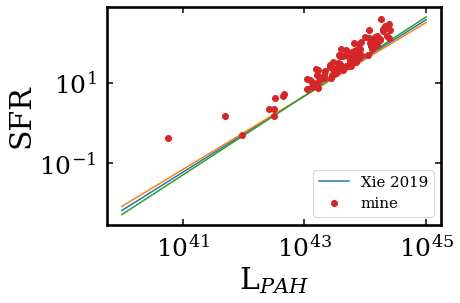

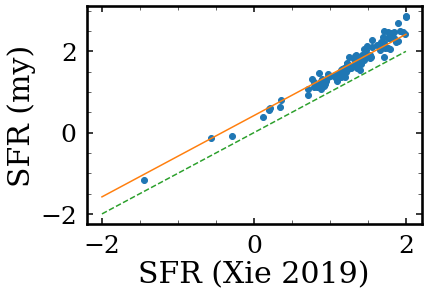

In [481]:
# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

df = mx
L_pah = df.L_f62 + df.L_f77 + df.L_f83 + df.L_f86 + df.L_f113
x = 10**np.arange(40, 46)
p1 = [1E40, 1E45]
p2 = np.array([10**(0.948*(np.log10(1E40)-43)+0.675), 10**(0.948*(np.log10(1E45)-43)+0.675)])
p3 = [10**((0.948-0.034)*(np.log10(1E40)-43)+0.675), 10**((0.948-0.034)*(np.log10(1E45)-43)+0.675)]
p4 = [10**((0.948+0.034)*(np.log10(1E40)-43)+0.675), 10**((0.948+0.034)*(np.log10(1E45)-43)+0.675)]

plt.figure()
plt.plot(p1, p2, label='Xie 2019')
plt.plot(p1, p3, label='_nolegend_')
plt.plot(p1, p4, label='_nolegend_')


plt.plot(L_pah, df.sf_Ne, 'o', label='mine')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'L$_{PAH}$')
plt.ylabel('SFR')
plt.legend(loc=4, fontsize=15)

# --------------------------------------------------------------------------------
x = 0.948*(np.log10(L_pah)-43)+0.675
y = -6.79 + np.log10(df.L_f33/const.L_sun.to('erg/s').value)

model = models.Linear1D(slope=1, fixed={'slope':True})    
fitter = fitting.LinearLSQFitter()

best_fit = fitter(model, x, y)
print(best_fit)

plt.figure()
plt.plot(x, y, 'o')
plt.plot([-2, 2], best_fit([-2, 2]))
# plt.xscale('log')
# plt.yscale('log')
plt.plot([-2, 2], [-2, 2], '--')
plt.xlabel('SFR (Xie 2019)')
plt.ylabel('SFR (my)')

In [365]:
IIZw40.columns

Index(['irc_id', 'tau_H2O', 'tau_Si', 'x', 'x_unc', 'y', 'y_unc'], dtype='object')

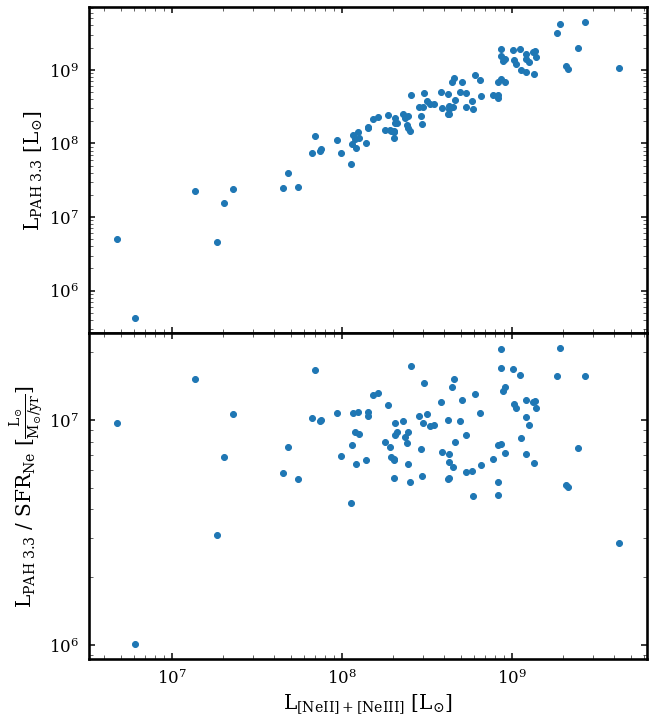

In [139]:
#matplotlib.rcParams.update({'ytick.right':True})

# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

mode = 'mx'
if mode == 'mx':
    df = mx
if mode == 'oc':
    df = oc

L_sun = const.L_sun.to('erg/s').value    

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(10, 12), sharex=True)
ax1.scatter(df.L_Ne_comb/L_sun, df.L_f33/L_sun)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'L$_\mathrm{PAH \ 3.3}$ [L$_{\odot}$]')

ax2.scatter(df.L_Ne_comb/L_sun, df.L_f33/L_sun / df.sf_Ne)
ax2.set_yscale('log')
ax2.set_xlabel(r'L$_\mathrm{[NeII]+[NeIII]}$ [L$_{\odot}$]')
ax2.set_ylabel(r'L$\mathrm{_{PAH \ 3.3}}$ / SFR$_\mathrm{Ne}$ [$\mathrm{\frac{L_{\odot}}{M_{\odot}/yr}}$]')
plt.subplots_adjust(hspace=0.)



correlation coef: 0.86


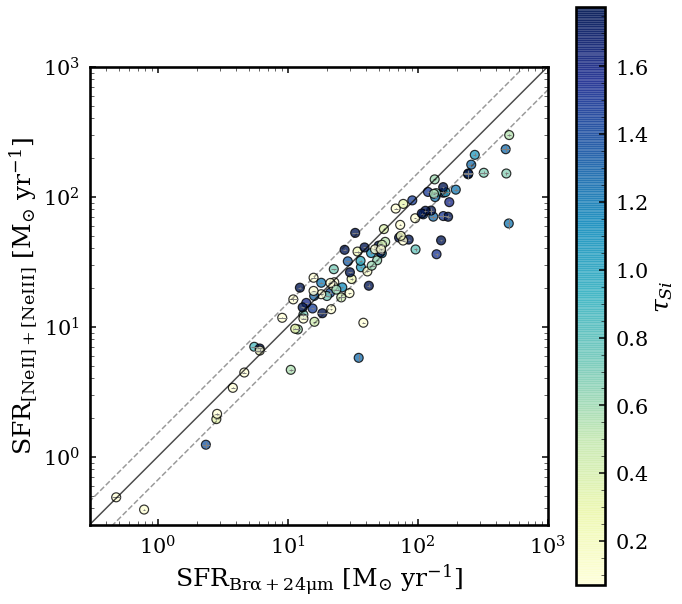

In [6]:
# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

mode = 'oc'
if mode == 'mx':
    df = mx
if mode == 'oc':
    df = oc

# The SFR derived using Halpha+S24 should have Halpha+S24 be taken from oc since Halpha provided in Murphy 2011 
# is the "observed" Halpha rather than the extinction-corrected Halpha.

print("correlation coef: {:.2f}".format(np.corrcoef(df.sf_Halpha_S24, df.sf_Ne)[0,1]))
np.std(df.sf_Halpha_S24/df.sf_Ne)

fig = plt.figure(num=7, figsize=(10,10))
ax = fig.add_subplot(111)

df['color'] = df.tau_Si 
#df.S24/df.conti43
#colors = np.random.rand(len(df))
#c = plt.cm.gist_rainbow(colors)

sc = ax.scatter(df.sf_Halpha_S24, df.sf_Ne, c=df.color,
         s=80, cmap='YlGnBu', linewidth=1.2,  #'RdGy_r'
         vmin=np.percentile(df.color,20), vmax=np.percentile(df.color,80), alpha=0.8, zorder=2, edgecolors='k')

cbar = fig.colorbar(sc, ax=ax, shrink=0.9)
cbar.ax.set_ylabel(r'$\tau _{Si}$')


#ax.scatter(df.sf_Halpha_S24, df.sf_Ne, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)
ax.errorbar(df.sf_Halpha_S24, df.sf_Ne, xerr=df.sf_Halpha_S24_unc.values, yerr=df.sf_Ne_unc.values,fmt='none', ecolor='gray', linewidth=1)
ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='-', alpha=0.7)
#ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='-', alpha=0.7)
std = 0.18 # dex
ax.plot([0.01, 1000],[10**(np.log10(0.01)-std), 10**(np.log10(1000)-std)], color='k', linestyle='--', alpha=0.4)
ax.plot([0.01, 1000],[10**(np.log10(0.01)+std), 10**(np.log10(1000)+std)], color='k', linestyle='--', alpha=0.4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'SFR$_\mathrm{Br\alpha + 24 \mu m}$ [M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR$_\mathrm{[Ne II]+[Ne III]}$ [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlim([0.3, 1000])
ax.set_ylim([0.3, 1000])
fig.gca().set_aspect('equal')
plt.tight_layout()
#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/SFR_Bralpha+S24_Ne_'+mode+'.pdf')

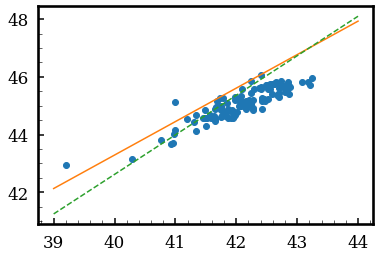

In [165]:
plt.figure()
plt.plot(np.log10(mx_rd.L_f33), np.log10(mx_rd.L_IR), 'o')

x = np.arange(39, 45)
y = 1.16 * x - 3.11
plt.plot(x, y)
y = 1.37 * x - 12.18
plt.plot(x, y, '--')

83    0.607773
Name: sf_Halpha_S24, dtype: float64
83    0.410813
Name: sf_Ne, dtype: float64


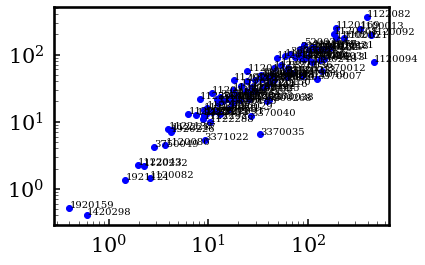

In [37]:
ax = pcs.plotlabel(df.sf_Halpha_S24, df.sf_Ne, df.irc_id)
ax.set_xscale('log')
ax.set_yscale('log')


IIZw40 = df[df.irc_id == '1420298']
print(IIZw40.sf_Halpha_S24)
print(IIZw40.sf_Ne)

(10, 1000)

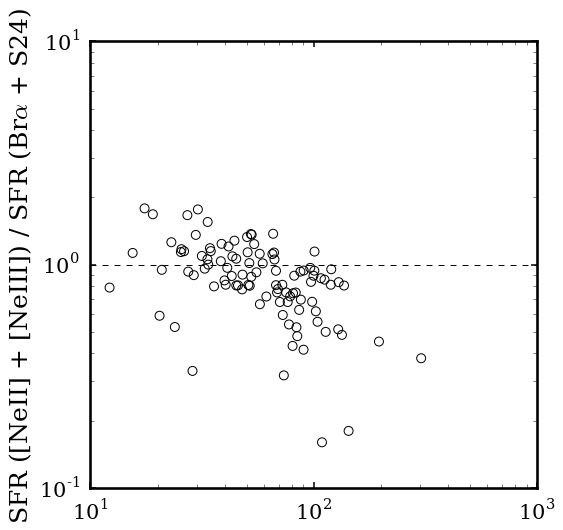

In [132]:
fig = plt.figure(num=7, figsize=(8,8))
ax = fig.add_subplot(111)

# sc = ax.scatter(df.sf_Halpha_S24, df.sf_Ne, c=df.color,
#          s=60, cmap=cm, linewidth=1.2, 
#          vmin=10., vmax=100, alpha=0.8, zorder=2)
# cbar = fig.colorbar(sc, ax=ax, shrink=0.9)

#ax.scatter(df.tau_Si+df.tau_H2O, df.sf_Ne/df.sf_Halpha_S24, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)

ax.scatter(df.color, df.sf_Ne/df.sf_Halpha_S24, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)
ax.hlines(1, xmin=10, xmax=1000, linestyle='dashed')

#ax.scatter(df.sf_Halpha_S24, df.sf_Ne, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)
# ax.errorbar(df.sf_Halpha_S24, df.sf_Ne, xerr=df.sf_Halpha_S24_unc.values, yerr=df.sf_Ne_unc.values,fmt='none', capsize=3, ecolor='gray')
# ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlabel(r'S24 / 4.3')
ax.set_ylabel(r'SFR ([NeII] + [NeIII]) / SFR (Br$\alpha$ + S24)')
#ax.set_xlim([0.01, 10])
ax.set_xlim([10, 1000])
# ax.set_ylim([0.1, 1000])
# fig.gca().set_aspect('equal')
# plt.tight_layout()

(0.01, 10)

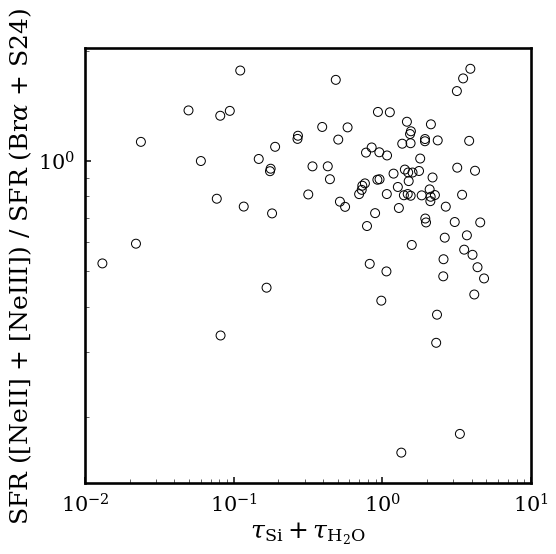

In [112]:
fig = plt.figure(num=7, figsize=(8,8))
ax = fig.add_subplot(111)

# sc = ax.scatter(df.sf_Halpha_S24, df.sf_Ne, c=df.color,
#          s=60, cmap=cm, linewidth=1.2, 
#          vmin=10., vmax=100, alpha=0.8, zorder=2)
# cbar = fig.colorbar(sc, ax=ax, shrink=0.9)

ax.scatter(df.tau_Si+df.tau_H2O, df.sf_Ne/df.sf_Halpha_S24, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)

#ax.scatter(df.color, df.sf_Ne/df.sf_Halpha_S24, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)
ax.hlines(1, xmin=10, xmax=1000, linestyle='dashed')

#ax.scatter(df.sf_Halpha_S24, df.sf_Ne, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)
# ax.errorbar(df.sf_Halpha_S24, df.sf_Ne, xerr=df.sf_Halpha_S24_unc.values, yerr=df.sf_Ne_unc.values,fmt='none', capsize=3, ecolor='gray')
# ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\tau \mathrm{_{Si}}+\tau \mathrm{_{H_{2}O}}$')
ax.set_ylabel(r'SFR ([NeII] + [NeIII]) / SFR (Br$\alpha$ + S24)')
ax.set_xlim([0.01, 10])
#ax.set_xlim([10, 1000])
# ax.set_ylim([0.1, 1000])
# fig.gca().set_aspect('equal')
# plt.tight_layout()

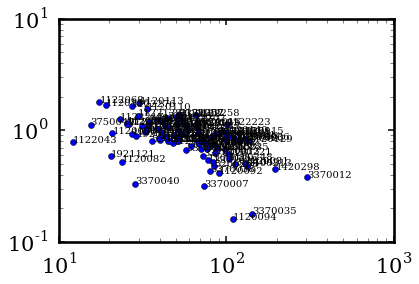

In [107]:
ax = pcs.plotlabel(df.color, df.sf_Ne/df.sf_Halpha_S24, df.irc_id)
ax.set_xscale('log')
ax.set_yscale('log')

In [100]:
a = df[df.color == np.max(color)]
print(a.irc_id)
print(a.color)
print(a.S24)
print(a.conti43)

92    3370012
Name: irc_id, dtype: object
92    303.033721
Name: color, dtype: float64
92    2005.049
Name: S24, dtype: float64
92    6.616587
Name: conti43, dtype: float64


In [65]:
import imp
imp.reload(tl)

<module 'tl_pah_akari' from '/Users/thomaslai/Documents/astro/PAH/IRC_IRS_cmbspec/tl_pah_akari.py'>

In [44]:
mx[mx.irc_id == '1120092'].sf_Halpha_S24

18    475.423437
Name: sf_Halpha_S24, dtype: float64

In [ ]:
matplotlib.rcParams.update({'font.size': 30})

/Users/thomaslai/anaconda3/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]

[6.88771151 6.92190757 7.03215762 7.1941954 ]
low tau (<0.5) mean: 7581271.20
low tau (<0.5) std: 2033426.34
[6.87134948 6.8510764  6.77595547 6.77399978]
low tau (<0.5) mean: 7408993.35
low tau (<0.5) std: 1954315.82
[0.13615374 1.04696351 2.19316688 3.64205332]
[6.78926093 6.77354032 6.6865145  6.74164191]
[6.87134948 6.8510764  6.77595547 6.77399978]
[6.98468059 6.89029319 6.86709857 6.78987229]
6611464.5755594075
6.8202976753144915


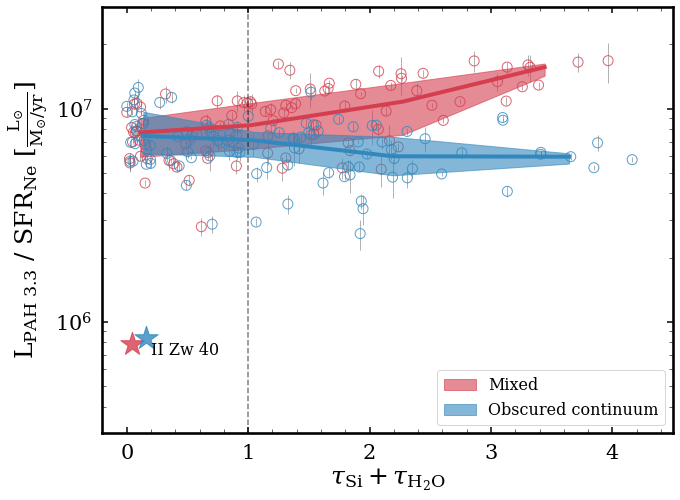

In [20]:
from bokeh.palettes import Spectral
from astropy import constants as const
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches


# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

# Add L_f33_unc
mx['L_f33_unc'] = mx.L_f33 * mx.f33_unc/mx.f33
oc['L_f33_unc'] = oc.L_f33 * oc.f33_unc/oc.f33

Spectral_red = Spectral[11][-2]  
Spectral_blue = Spectral[11][1] 

fig = plt.figure(figsize=(10,6*10/8))
ax = fig.add_subplot(111)

lwtau_data = []

for df in [mx, oc]:
    if df is mx:
        c = Spectral_red
        leg0 = 'Mixed'
    if df is sc:
        c = 'g'
        leg0 = 'screen'
        #leg1 = r'L$\mathrm{_{IR}}$ < 10$^{12}$L$_{\odot}$'
        #leg2 = r'L$\mathrm{_{IR}}$ $\geq$ 10$^{12}$L$_{\odot}$'
    if df is oc:
        c = Spectral_blue
        leg0 = 'Obscured continuum'
        #leg1 = '_nolegend_'
        #leg2 = '_nolegend_'
    #non_ULIRG = df[df.log_lir < 12]
    #ULIRG = df[(df.log_lir >= 12) & (df.log_lir < 13)]
    
    # Add L_f33 in unit of L_sun
    df['L_f33_in_L_sun'] = df.L_f33/const.L_sun.to('erg/s').value
#     bin_centers, bin_Q1, bin_mean, bin_Q3, bin_stdevs = tl.binning_ymean(df.tau_Si+df.tau_H2O, df.L_f33_in_L_sun/df.sf,
#                   n_bins=[np.percentile(df.tau_Si + df.tau_H2O, i) for i in [0, 10, 25, 50, 75, 100]])

    df = df.dropna(subset=['sf_akari'])
    
    # Plot II Zw 40 results
    IIZw40 = df[df.irc_id == '1420298']
    ax.scatter(IIZw40.tau_Si+IIZw40.tau_H2O, IIZw40.L_f33_in_L_sun/IIZw40.sf_Ne, marker='*', s=600, facecolor=c, alpha=0.8)
    
    # Exclude II Zw 40 from df
    df = df[df.irc_id != '1420298']
    
    lwtau = df[df.tau_Si + df.tau_H2O < 1]
    
    #n_bins = [np.percentile(df.tau_Si+df.tau_H2O, i) for i in np.linspace(0, 100, 8)]
    bin_centers, bin_Q1, bin_y, bin_Q3, bin_stdevs = tl.binning_ymed(df.tau_Si+df.tau_H2O, 
                                                                         df.L_f33_in_L_sun/df.sf_Ne,
                                                                         #n_bins=np.arange(-1, 6)
                                                                         n_bins=np.linspace(-1, 4.5, 5))
                                                                         #n_bins=np.array([-6., -1.,  0.,  1.]))
                                                                         #n_bins=[np.percentile(df.tau_Si+df.tau_H2O, i) for i in [0, 25, 50, 75, 100]])   
    
    
    
    ax.fill_between(bin_centers, bin_Q1, bin_Q3, color=c, alpha=0.6, label=leg0)
    ax.plot(bin_centers, bin_y, color=c, zorder=5, linewidth=4)#, label=leg0)
    
    ax.scatter(df.tau_Si+df.tau_H2O, df.L_f33_in_L_sun/df.sf_Ne, marker='o', s=100,
               facecolor='none', edgecolor=c, alpha=0.8)
    
    yerr = df.L_f33_in_L_sun/df.sf_Ne * np.sqrt((df.L_f33_unc/df.L_f33)**2+(df.sf_Ne_unc/df.sf_Ne)**2)
    ax.errorbar(df.tau_Si+df.tau_H2O, df.L_f33_in_L_sun/df.sf_Ne, yerr=yerr, fmt='none', color='k', linewidth=1, zorder=0, label='_nolegend_', alpha=0.3)
    

    
#     ax.scatter(df.tau_Si, df.L_f33_in_L_sun/df.sf, marker='.', 
#                facecolor='none', edgecolor=c, s=40, alpha=0.8)

    tmp = lwtau.L_f33_in_L_sun/lwtau.sf_Ne
    lwtau_data.append(tmp)

    print(np.log10(bin_y))

    
    print("low tau (<0.5) mean: {:.2f}".format(np.mean(tmp)))
    print("low tau (<0.5) std: {:.2f}".format(np.std(tmp)))
    
ax.annotate('II Zw 40', xy=(0.2, 7E5), #xytext=(0.6, 4E5),
           # arrowprops=dict(facecolor='black', shrink=0.02, width=1),
            fontsize=16)

#el = Ellipse((0, 0), 10, 20, facecolor='r', alpha=0.5)

# ax.annotate('II Zw 40',
#             xy=(0.05, 8E5), xycoords='data',
#             xytext=(0.4, 4E5), textcoords='offset points',
#             size=20,
#             # bbox=dict(boxstyle="round", fc="0.8"),
#             arrowprops=dict(arrowstyle="fancy",
#                             fc="0.6", ec="none",
#                             patchB=el,
#                             connectionstyle="angle3,angleA=0,angleB=-90"))

ax.vlines(1, ymin=3E5, ymax=3E7, linestyle='dashed', alpha=0.5)

print(bin_centers)
print(np.log10(bin_Q1))
print(np.log10(bin_y))
print(np.log10(bin_Q3))
print(np.mean(bin_y))
print(np.log10(np.mean(bin_y)))




ax.set_xlabel(r'$\tau \mathrm{_{Si}}+\tau \mathrm{_{H_{2}O}}$')
ax.set_ylabel(r'L$\mathrm{_{PAH \ 3.3}}$ / SFR$_\mathrm{Ne}$ [$\mathrm{\frac{L_{\odot}}{M_{\odot}/yr}}$]')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(-0.2, 4.5)
ax.set_ylim(3E5, 3E7)
ax.legend(loc=4, fontsize=16)

#ax.annotate('II Zw 40', xy=(0.3, 5E5), fontsize=16)

fig.tight_layout()
#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/SFR_calibration.pdf')

# ==========================================================================


array([-2., -1.,  0.,  1.])

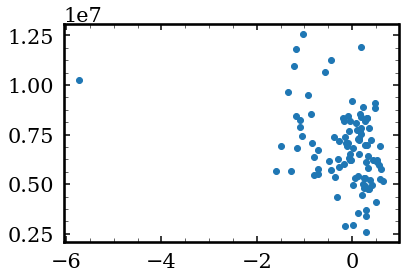

In [12]:
plt.figure()
plt.plot(np.log10(df.tau_Si+df.tau_H2O), df.L_f33_in_L_sun/df.sf_Ne, 'o')
np.linspace(-2, 1, 4)

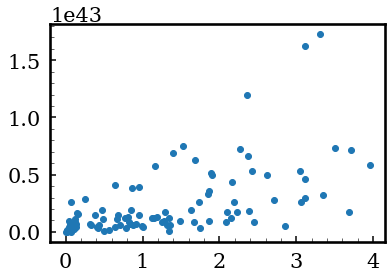

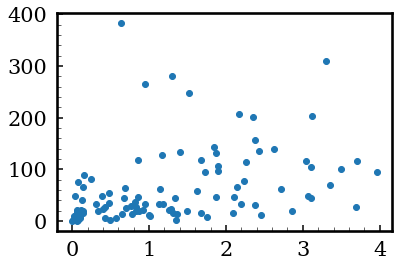

In [90]:
df = mx
plt.figure()
plt.plot(df.tau_Si + df.tau_H2O, df.L_f33, 'o')
plt.figure()
plt.plot(df.tau_Si + df.tau_H2O, df.sf_akari, 'o')

bin_center: [  4.35498913  36.77810739 173.56334489]
bin_y: [ 8550576.38555835  9443629.65183939 11662063.16760956]
[6.93199539 6.97513895 7.06677539]
bin_center: [  4.00996072  39.6671349  176.3224751 ]
bin_y: [6776424.88987527 6656967.35051454 4628314.03896306]
[6.83100063 6.82327643 6.66542282]
[  4.00996072  39.6671349  176.3224751 ]
[6.83100063 6.82327643 6.66542282]


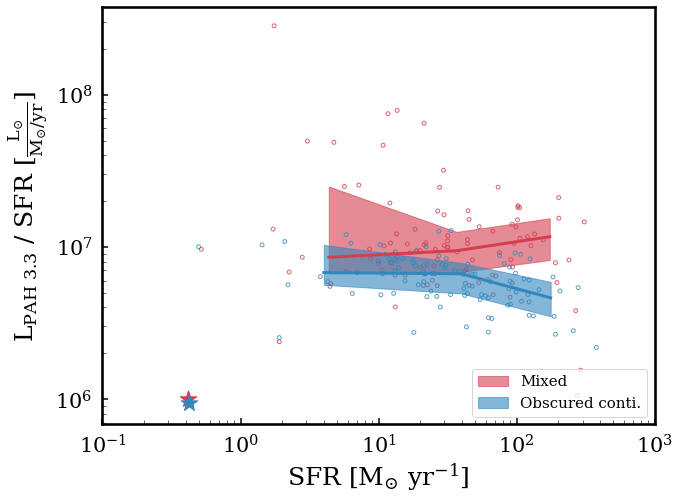

In [68]:
from bokeh.palettes import Spectral
from astropy import constants as const
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches

# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")


Spectral_red = Spectral[11][-2]  
Spectral_blue = Spectral[11][1] 
fig = plt.figure(figsize=(10,6*10/8))
ax = fig.add_subplot(111)

lwtau_data = []

for df in [mx, oc]:
    if df is mx:
        c = Spectral_red
        leg0 = 'Mixed'
    if df is sc:
        c = 'g'
        leg0 = 'Screen'
        #leg1 = r'L$\mathrm{_{IR}}$ < 10$^{12}$L$_{\odot}$'
        #leg2 = r'L$\mathrm{_{IR}}$ $\geq$ 10$^{12}$L$_{\odot}$'
    if df is oc:
        c = Spectral_blue
        leg0 = 'Obscured conti.'
        #leg1 = '_nolegend_'
        #leg2 = '_nolegend_'
    #non_ULIRG = df[df.log_lir < 12]
    #ULIRG = df[(df.log_lir >= 12) & (df.log_lir < 13)]
    
    # Add L_f33 in unit of L_sun
    df['L_f33_in_L_sun'] = df.L_f33/const.L_sun.to('erg/s').value
#     bin_centers, bin_Q1, bin_mean, bin_Q3, bin_stdevs = tl.binning_ymean(df.tau_Si+df.tau_H2O, df.L_f33_in_L_sun/df.sf,
#                   n_bins=[np.percentile(df.tau_Si + df.tau_H2O, i) for i in [0, 10, 25, 50, 75, 100]])

    df = df.dropna(subset=['sf_akari'])
    
    #lwtau = df[df.tau_Si + df.tau_H2O < 0.5]
    
    n_bins = [np.percentile(df.sf_akari, i) for i in np.linspace(0, 100, 4)]
    bin_centers, bin_Q1, bin_y, bin_Q3, bin_stdevs = tl.binning_ymed(df.sf_akari, 
                                                                     df.L_f33_in_L_sun/df.sf_akari,
                                                                     n_bins = [0.1, 10, 100, 1000])
                                                                     #n_bins=n_bins)    
    
    print("bin_center: {}".format(bin_centers))
    print("bin_y: {}".format(bin_y))
    
    ax.fill_between(bin_centers, bin_Q1, bin_Q3, color=c, alpha=0.6, label=leg0)
    ax.plot(bin_centers, bin_y, color=c, zorder=5, linewidth=3)#, label=leg0)
    
    ax.scatter(df.sf_akari, df.L_f33_in_L_sun/df.sf_akari, marker='.', 
               facecolor='none', edgecolor=c, s=60, alpha=0.8)

    # Plot II Zw 40 results
    IIZw40 = df[df.irc_id == '1420298']
    ax.scatter(IIZw40.sf_akari, IIZw40.L_f33_in_L_sun/IIZw40.sf_akari, marker='*', s=300, facecolor=c)
    
#     ax.scatter(df.tau_Si, df.L_f33_in_L_sun/df.sf, marker='.', 
#                facecolor='none', edgecolor=c, s=40, alpha=0.8)

#     tmp = lwtau.L_f33_in_L_sun/lwtau.sf_akari
#     lwtau_data.append(tmp)

    print(np.log10(bin_y))




# print("low tau (<0.5) mean: {:.2f}".format(np.mean(tmp)))
# print("low tau (<0.5) std: {:.2f}".format(np.std(tmp)))
    
# ax.annotate('II Zw 40', xy=(0.2, 8E5), xytext=(0.6, 4E5),
#             arrowprops=dict(facecolor='black', shrink=0.02, width=1),
#             fontsize=16)


#ax.set_ylim(3E5, 3E7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 1000)


print(bin_centers)
#print(np.log10(bin_Q1))
print(np.log10(bin_y))

#print(np.log10(bin_Q3))
#print(np.mean(bin_y))
#print(np.log10(np.mean(bin_y)))




ax.set_xlabel(r'SFR [$\mathrm{M_{\odot} \ yr^{-1}}$]')
ax.set_ylabel(r'L$\mathrm{_{PAH \ 3.3}}$ / SFR [$\mathrm{\frac{L_{\odot}}{M_{\odot}/yr}}$]')
ax.legend(loc=4, fontsize=15)

#ax.annotate('II Zw 40', xy=(0.3, 5E5), fontsize=16)

fig.tight_layout()
#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/SFR_calibration.pdf')

# ==========================================================================


In [79]:
len(df.L_f33_in_L_sun)#/np.mean([mx.sf_akari, oc.sf_akari], axis=0)

101

(array([53., 20., 13.,  7.,  2.,  2.,  1.,  2.,  0.,  1.]),
 array([  0.42222239,  38.15877139,  75.8953204 , 113.6318694 ,
        151.36841841, 189.10496741, 226.84151642, 264.57806542,
        302.31461443, 340.05116343, 377.78771244]),
 <a list of 10 Patch objects>)

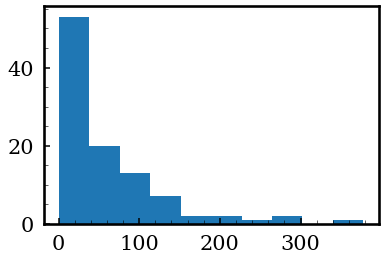

In [42]:
plt.figure()
plt.hist(df.sf_akari)

In [48]:
n_bins

[0.42222238733148443, 21.135687542485414, 61.26693921277622, 377.7877124383867]

In [15]:
(10**6.97-10**6.77)/10**6.77

0.5848931924611142

In [18]:
10**7.22 / 10**6.77

2.818382931264455

3.3333333333333335

L$_{3.3}$ = 10$^{6.84}$ $\times$ SFR 

/Users/thomaslai/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


(0.0, 4.5)

/Users/thomaslai/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


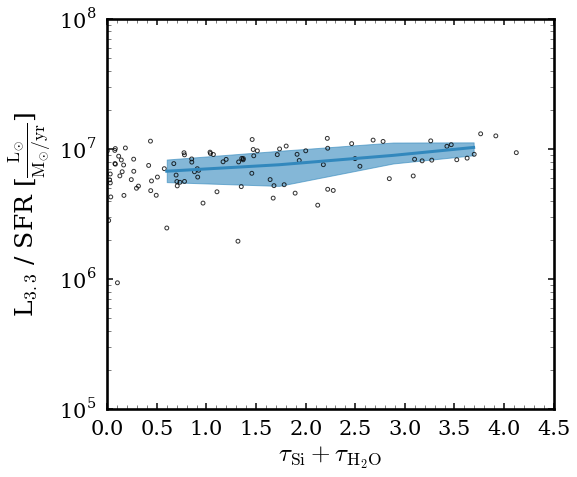

In [60]:
# average L_33 / SFR in mixed and obscured conti. 

comb_df = mx.merge(oc, on='irc_id', how='inner')
df = pd.DataFrame({})

df['avg_ratio_L33_over_SFR'] = np.mean([comb_df.L_f33_in_L_sun_x/comb_df.sf_akari_x, 
                                        comb_df.L_f33_in_L_sun_y/comb_df.sf_akari_y], axis=0)
# average tau Si + tau H2O
df['tau'] = np.mean([comb_df.tau_Si_x+comb_df.tau_H2O_x, 
                     comb_df.tau_Si_y+comb_df.tau_H2O_y], axis=0)

bin_centers, bin_Q1, bin_mean, bin_Q3, bin_stdevs = tl.binning_ymean(df.tau, df.avg_ratio_L33_over_SFR,
                  n_bins=np.linspace(-1, 4.5, 6))
                                                                     #n_bins=[np.percentile(df.tau, i) for i in [0, 10, 25, 50, 75, 100]])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)

ax.fill_between(bin_centers, bin_Q1, bin_Q3, color=Spectral_blue, alpha=0.6, label=leg0)
ax.plot(bin_centers, bin_mean, color=Spectral_blue, zorder=5, linewidth=3)
    
ax.scatter(df.tau, df.avg_ratio_L33_over_SFR, marker='.', 
           facecolor='none', edgecolor='k', s=60, alpha=0.8)

ax.set_xlabel(r'$\tau \mathrm{_{Si}}+\tau \mathrm{_{H_{2}O}}$')
ax.set_ylabel(r'L$\mathrm{_{3.3}}$ / SFR [$\mathrm{\frac{L_{\odot}}{M_{\odot}/yr}}$]')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.0, 4.5)
#ax.set_ylim(3E5, 3E7)

In [12]:
df.sf_akari.iloc[98]

nan

(0.0, 4.5)

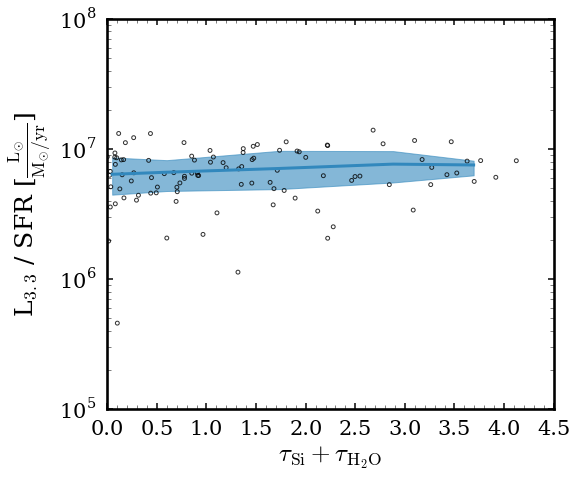

In [40]:
# average L_33 / SFR in mixed and obscured conti. 

comb_df = mx.merge(oc, on='irc_id', how='inner')
df = pd.DataFrame({})

df['avg_ratio_L33_over_SFR'] = np.mean([comb_df.L_f33_in_L_sun_x/comb_df.sf_akari_x, 
                                        comb_df.L_f33_in_L_sun_y/comb_df.sf_akari_y], axis=0)
# average tau Si + tau H2O
df['tau'] = np.mean([comb_df.tau_Si_x+comb_df.tau_H2O_x, 
                     comb_df.tau_Si_y+comb_df.tau_H2O_y], axis=0)

bin_centers, bin_Q1, bin_mean, bin_Q3, bin_stdevs = tl.binning_ymean(df.tau, df.avg_ratio_L33_over_SFR,
                  n_bins=np.linspace(-1, 4.5, 6))
                                                                     #n_bins=[np.percentile(df.tau, i) for i in [0, 10, 25, 50, 75, 100]])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)

ax.fill_between(bin_centers, bin_Q1, bin_Q3, color=Spectral_blue, alpha=0.6, label=leg0)
ax.plot(bin_centers, bin_mean, color=Spectral_blue, zorder=5, linewidth=3)
    
ax.scatter(df.tau, df.avg_ratio_L33_over_SFR, marker='.', 
           facecolor='none', edgecolor='k', s=60, alpha=0.8)

ax.set_xlabel(r'$\tau \mathrm{_{Si}}+\tau \mathrm{_{H_{2}O}}$')
ax.set_ylabel(r'L$\mathrm{_{3.3}}$ / SFR [$\mathrm{\frac{L_{\odot}}{M_{\odot}/yr}}$]')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.0, 4.5)
#ax.set_ylim(3E5, 3E7)

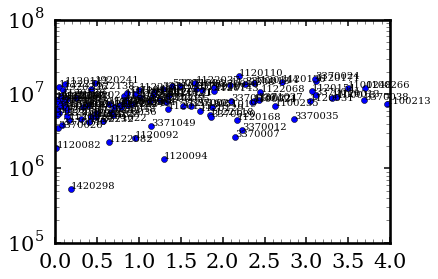

In [448]:
df = mx
ax = pcs.plotlabel(df.tau_Si+df.tau_H2O, df.L_f33_in_L_sun/df.sf, df.irc_id)
ax.set_yscale('log')

num in oc: 102
before 3-sigma clipping -- number: 102
after 3-sigma clipping -- number: 95
In oc after 3-sigma clipping: L_Ne_comb / L_f33= 1.561 +- 0.423
L_f33 / L_Ne: 0.66 +- 0.20
median = 0.66


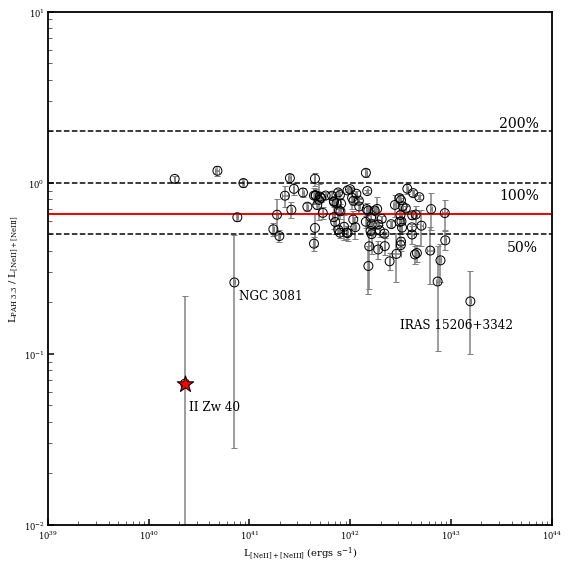

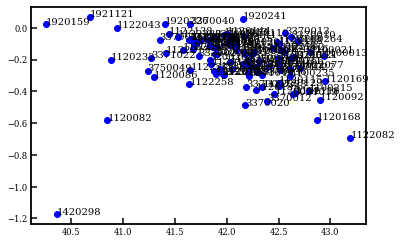

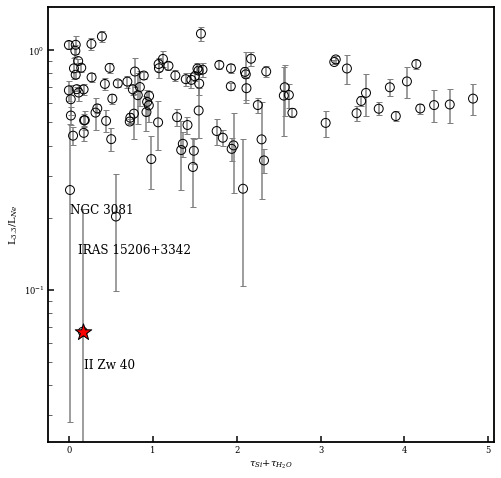

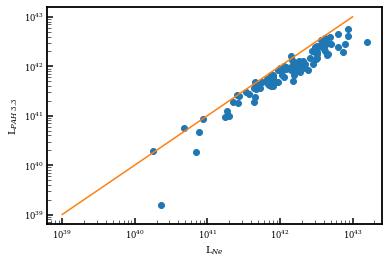

In [12]:
from astropy.stats import sigma_clip

mode = 'oc'

#ax.scatter(np.log10(df.L_NeII + df.L_NeIII), np.log10(df.L_f33 / (df.L_NeII + df.L_NeIII)), marker='o', edgecolor='k', facecolor='none', s=80)

sf_df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
print("num in {}: {:.0f}".format(mode, len(sf_df)))
r = (sf_df.L_NeII + sf_df.L_NeIII) / sf_df.L_f33
print("before 3-sigma clipping -- number: {:.0f}".format(len(r)))
filter_data = sigma_clip(r, sigma=3)
r = r[~filter_data.mask]
print("after 3-sigma clipping -- number: {:.0f}".format(len(r)))

#print("In fs: L_f33 / L_Ne_comb = {:.3f} +- {:.3f}".format(np.mean(1/r), np.std(1/r)))
print("In {} after 3-sigma clipping: L_Ne_comb / L_f33= {:.3f} +- {:.3f}".format(mode, np.mean(r), np.std(r)))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
# for i in [0, 1]:
#     if i == 0:
#         df = sf_df[sf_df.log_LIR <= 11.5]
#         ec = 'b'
#     if i == 1:
#         df = sf_df[sf_df.log_LIR > 11.5]
#         ec = 'r'
df = sf_df
ec = 'k'
ax.scatter(df.L_Ne_comb, df.L_f33 / df.L_Ne_comb, marker='o', edgecolor=ec, facecolor='none', s=80, zorder=3)

#df['L_Ne_comb'] = df.L_NeII + df.L_NeIII
#df['L_Ne_comb_unc'] = np.sqrt(df.L_NeII_unc**2 + df.L_NeIII_unc**2)

#xerr = np.sqrt(np.sqrt(df.L_NeII_unc**2 + df.L_NeIII_unc**2) / ((df.L_NeII + df.L_NeIII) * np.log(10)))
xerr = df.L_Ne_comb_unc
yerr = np.sqrt((df.f33_unc/df.f33)**2 + (df.L_Ne_comb_unc/df.L_Ne_comb)**2)
ax.errorbar(df.L_Ne_comb, df.L_f33/df.L_Ne_comb, 
            xerr=xerr.values, yerr=yerr.values, fmt='none', capsize=3, ecolor='gray', zorder=1)

#ax.hlines(np.mean(df.L_f33 / (df.L_NeII + df.L_NeIII)), xmin=1E39, xmax=1E45, linestyle='-', color='r', linewidth=2)

ratio = df.L_f33/df.L_Ne_comb
#print("percentage of galaxy in between 0.5 and 2: {:.2f}%".format(100*len(ratio[(ratio > 0.5) & (ratio < 2)]) / len(ratio)))
# ==============================================================================================
# df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fp_SFR.pkl")
# print("num in fp: {:.0f}".format(len(df)))
# ax.scatter(df.L_Ne_comb, df.L_f33 / df.L_Ne_comb, marker='o', edgecolor='b', facecolor='none', s=30, zorder=3)


ax.set_xscale('log')
ax.set_yscale('log')

# Special cases:
IIZw40 = df[df.irc_id == '1420298']
ax.scatter(IIZw40.L_NeII + IIZw40.L_NeIII, IIZw40.L_f33 / (IIZw40.L_NeII + IIZw40.L_NeIII), marker='*', 
           edgecolor='k', facecolor='red', s=300, zorder=3)
ax.annotate('II Zw 40', xy=((IIZw40.L_NeII + IIZw40.L_NeIII)*1.1, 
                            IIZw40.L_f33 / (IIZw40.L_NeII + IIZw40.L_NeIII)*0.7), fontsize=12)

NGC3081 = df[df.irc_id == '1120082']
ax.annotate('NGC 3081', xy=((NGC3081.L_NeII + NGC3081.L_NeIII)*1.1, 
                            NGC3081.L_f33 / (NGC3081.L_NeII + NGC3081.L_NeIII)*0.8), fontsize=12)


IRAS15206 = df[df.irc_id == '1122082']
ax.annotate('IRAS 15206+3342', xy=((IRAS15206.L_NeII + IRAS15206.L_NeIII)*0.2, 
                            IRAS15206.L_f33 / (IRAS15206.L_NeII + IRAS15206.L_NeIII)*0.7), fontsize=12)

ax.annotate('200%', xy=(3E43, 2.1), fontsize=14)
ax.annotate('100%', xy=(3E43, 0.8), fontsize=14)
ax.annotate('50%', xy=(3.6E43, 0.4), fontsize=14)

print("L_f33 / L_Ne: {:.2f} +- {:.2f}".format(np.mean(df.L_f33 / (df.L_NeII + df.L_NeIII)), np.std(df.L_f33 / (df.L_NeII + df.L_NeIII))))



ax.hlines(np.median(df.L_f33 / (df.L_NeII + df.L_NeIII)), xmin=1E39, xmax=1E45, linestyle='-', color='r', linewidth=2)
print("median = {:.2f}".format(np.median(df.L_f33 / (df.L_NeII + df.L_NeIII))))

ax.hlines(1, xmin=1E39, xmax=1E45, linestyle='dashed')
ax.hlines(2, xmin=1E39, xmax=1E45, linestyle='dashed')
ax.hlines(0.5, xmin=1E39, xmax=1E45, linestyle='dashed')
ax.set_xlabel(r'L$\mathrm{_{[NeII] + [NeIII]}}$ (ergs s$^{-1}$)')
ax.set_ylabel(r'L$\mathrm{_{PAH \ 3.3}}$ / L$_{\mathrm{[NeII] + [NeIII]}}$')
ax.set_xlim(1E39, 1E44)
ax.set_ylim(1E-2, 10)
fig.tight_layout()
#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/pah33_and_Ne_'+mode+'.pdf')
# -------------------------------
pcs.plotlabel(np.log10(df.L_NeII + df.L_NeIII), np.log10(df.L_f33 / (df.L_NeII + df.L_NeIII)), df.irc_id)
#fig.gca().set_aspect('equal')
# -------------------------------

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(df.tau_Si+df.tau_H2O, df.L_f33 / df.L_Ne_comb, marker='o', edgecolor='k', facecolor='none', s=80, zorder=3)

#df['L_Ne_comb'] = df.L_NeII + df.L_NeIII
#df['L_Ne_comb_unc'] = np.sqrt(df.L_NeII_unc**2 + df.L_NeIII_unc**2)

#xerr = np.sqrt(np.sqrt(df.L_NeII_unc**2 + df.L_NeIII_unc**2) / ((df.L_NeII + df.L_NeIII) * np.log(10)))
#xerr = df.L_Ne_comb_unc
yerr = np.sqrt((df.f33_unc/df.f33)**2 + (df.L_Ne_comb_unc/df.L_Ne_comb)**2)
ax.errorbar(df.tau_Si+df.tau_H2O, df.L_f33/df.L_Ne_comb, 
            yerr=yerr.values, fmt='none', capsize=3, ecolor='gray', zorder=1)

ax.set_xlabel(r'$\tau_{Si}$+$\tau_{H_{2}O}$')
ax.set_ylabel(r'L$_{3.3}$/L$_{Ne}$')
#ax.set_xscale('log')
ax.set_yscale('log')

# Special cases:
IIZw40 = df[df.irc_id == '1420298']
ax.scatter(IIZw40.tau_Si + IIZw40.tau_H2O, IIZw40.L_f33 / (IIZw40.L_NeII + IIZw40.L_NeIII), marker='*', 
           edgecolor='k', facecolor='red', s=300, zorder=3)
ax.annotate('II Zw 40', xy=((IIZw40.tau_Si + IIZw40.tau_H2O)*1.1, 
                            IIZw40.L_f33 / (IIZw40.L_NeII + IIZw40.L_NeIII)*0.7), fontsize=12)

NGC3081 = df[df.irc_id == '1120082']
ax.annotate('NGC 3081', xy=((NGC3081.tau_Si + NGC3081.tau_H2O)*1.1, 
                            NGC3081.L_f33 / (NGC3081.L_NeII + NGC3081.L_NeIII)*0.8), fontsize=12)


IRAS15206 = df[df.irc_id == '1122082']
ax.annotate('IRAS 15206+3342', xy=((IRAS15206.tau_Si + IRAS15206.tau_H2O)*0.2, 
                            IRAS15206.L_f33 / (IRAS15206.L_NeII + IRAS15206.L_NeIII)*0.7), fontsize=12)

# =======================================
plt.figure()
plt.plot(df.L_Ne_comb, df.L_f33, 'o')
plt.plot([1E39, 1E43], [1E39, 1E43])
plt.xlabel(r'L$_{Ne}$')
plt.ylabel(r'L$_{PAH \ 3.3}$')
plt.xscale('log')
plt.yscale('log')

# Test the relation between PAH 3.3 and SFR inferred from H$\alpha$+S24

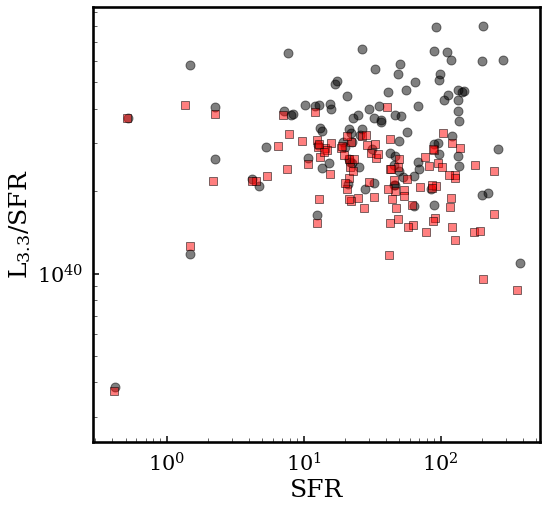

In [103]:
from astropy.stats import sigma_clip


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)



for mode, c, m in zip(['mx', 'oc'], ['k', 'r'], ['o', 's']):
    df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
    SFR = df.sf_Ne
    ax.scatter(SFR, df.L_f33 / SFR, marker=m, edgecolor='k', facecolor=c, s=80, zorder=3, alpha=0.5)
ax.set_xlabel('SFR')
ax.set_ylabel(r'L$_{3.3}$/SFR')
ax.set_xscale('log')
ax.set_yscale('log')



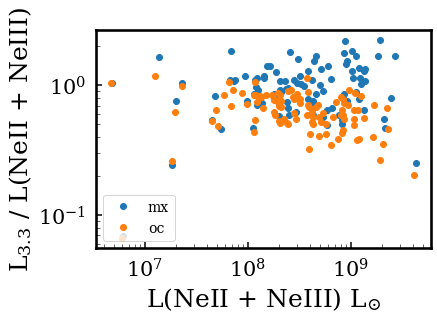

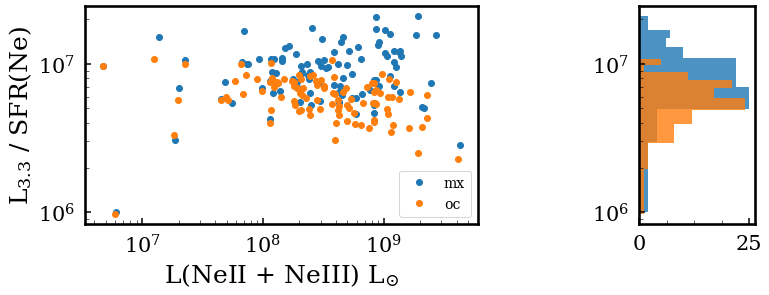

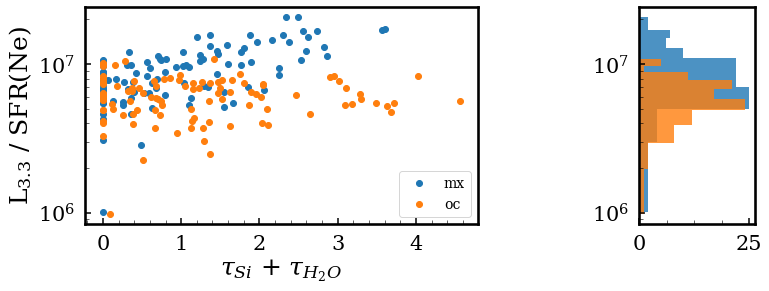

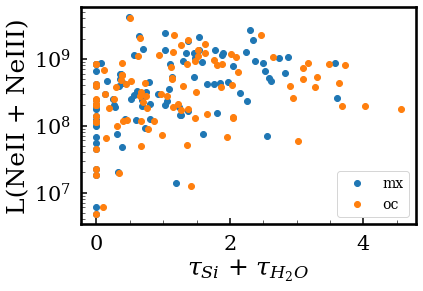

In [41]:
fig1 = plt.figure()
fig2 = plt.figure(figsize=(12,4))
fig3 = plt.figure(figsize=(12,4))
fig4 = plt.figure()

gs2 = fig2.add_gridspec(1, 5)
gs3 = fig3.add_gridspec(1, 5)


ax1 = fig1.add_subplot(111)
ax21, ax22 = fig2.add_subplot(gs2[0, 0:3]), fig2.add_subplot(gs2[0, 4])
ax31, ax32 = fig3.add_subplot(gs3[0, 0:3]), fig3.add_subplot(gs3[0, 4])
ax4 = fig4.add_subplot(111)

for mode in ['mx', 'oc']:

    df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
    
    ax1.plot(df.L_Ne_comb/const.L_sun.to('erg/s').value, df.L_f33 / df.L_Ne_comb, 'o', label=mode)
    
    ax21.plot(df.L_Ne_comb/const.L_sun.to('erg/s').value, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    ax22.hist(df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, orientation='horizontal', alpha=0.8)
    
    ax31.plot(df.tau_Si, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    #ax31.plot(df.tau_Si+df.tau_H2O, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    ax32.hist(df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, orientation='horizontal', alpha=0.8)
    
    ax4.plot(df.tau_Si, df.L_Ne_comb/const.L_sun.to('erg/s').value, 'o', label=mode)
    #ax4.plot(df.tau_Si+df.tau_H2O, df.L_Ne_comb/const.L_sun.to('erg/s').value, 'o', label=mode)
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'L(NeII + NeIII) L$_{\odot}$')
    ax1.set_ylabel(r'L$_\mathrm{3.3}$ / L(NeII + NeIII)')
    ax1.legend(loc=3, fontsize=14)
    
    ax21.set_xscale('log')
    ax21.set_yscale('log')
    ax21.set_xlabel(r'L(NeII + NeIII) L$_{\odot}$')
    ax21.set_ylabel(r'L$_\mathrm{3.3}$ / SFR(Ne)')
    ax21.legend(loc=4, fontsize=14)
    
    ax22.set_yscale('log')
    
    ax31.set_yscale('log')
    ax31.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
    ax31.set_ylabel(r'L$_\mathrm{3.3}$ / SFR(Ne)')
    ax31.legend(loc=4, fontsize=14)
    
    ax32.set_yscale('log')
    
    ax4.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
    ax4.set_ylabel('L(NeII + NeIII)')
    #ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.legend(loc=4, fontsize=14)

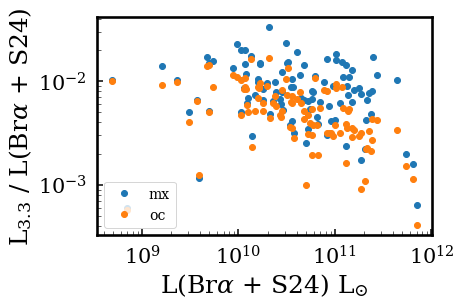

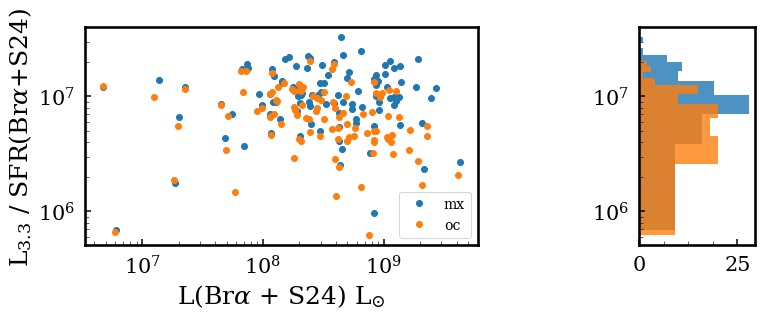

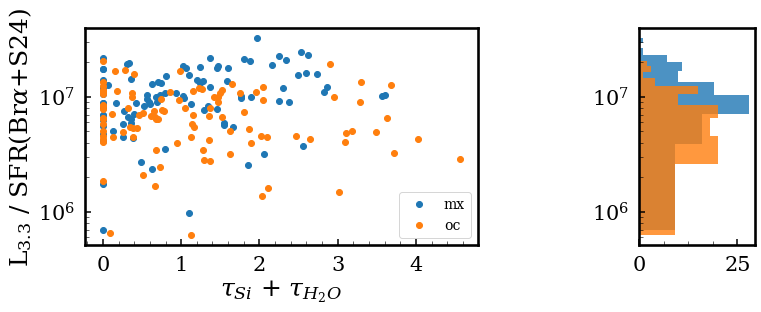

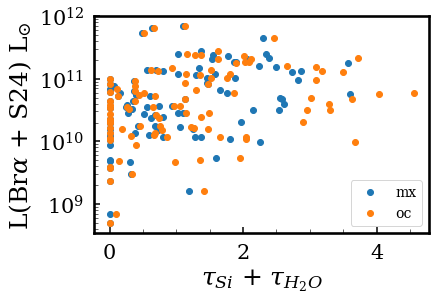

In [67]:
fig1 = plt.figure()
fig2 = plt.figure(figsize=(12,4))
fig3 = plt.figure(figsize=(12,4))
fig4 = plt.figure()

gs2 = fig2.add_gridspec(1, 5)
gs3 = fig3.add_gridspec(1, 5)


ax1 = fig1.add_subplot(111)
ax21, ax22 = fig2.add_subplot(gs2[0, 0:3]), fig2.add_subplot(gs2[0, 4])
ax31, ax32 = fig3.add_subplot(gs3[0, 0:3]), fig3.add_subplot(gs3[0, 4])
ax4 = fig4.add_subplot(111)

for mode in ['mx', 'oc']:

    df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")

    ax1.plot((df.L_Br_alpha + df.L_S24)/const.L_sun.to('erg/s').value, df.L_f33 / (df.L_Br_alpha + df.L_S24), 'o', label=mode)
    
    ax21.plot(df.L_Ne_comb/const.L_sun.to('erg/s').value, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Halpha_S24, 'o', label=mode)
    ax22.hist(df.L_f33/const.L_sun.to('erg/s').value / df.sf_Halpha_S24, orientation='horizontal', alpha=0.8)
    
    ax31.plot(df.tau_Si, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Halpha_S24, 'o', label=mode)
    #ax31.plot(df.tau_Si+df.tau_H2O, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    ax32.hist(df.L_f33/const.L_sun.to('erg/s').value / df.sf_Halpha_S24, orientation='horizontal', alpha=0.8)
    
    ax4.plot(df.tau_Si, (df.L_Br_alpha + df.L_S24)/const.L_sun.to('erg/s').value, 'o', label=mode)
    #ax4.plot(df.tau_Si+df.tau_H2O, df.L_Ne_comb/const.L_sun.to('erg/s').value, 'o', label=mode)
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'L(Br$\alpha$ + S24) L$_{\odot}$')
    ax1.set_ylabel(r'L$_\mathrm{3.3}$ / L(Br$\alpha$ + S24)')
    ax1.legend(loc=3, fontsize=14)
    
    ax21.set_xscale('log')
    ax21.set_yscale('log')
    ax21.set_xlabel(r'L(Br$\alpha$ + S24) L$_{\odot}$')
    ax21.set_ylabel(r'L$_\mathrm{3.3}$ / SFR(Br$\alpha$+S24)')
    ax21.legend(loc=4, fontsize=14)
    
    ax22.set_yscale('log')
    
    ax31.set_yscale('log')
    ax31.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
    ax31.set_ylabel(r'L$_\mathrm{3.3}$ / SFR(Br$\alpha$+S24)')
    ax31.legend(loc=4, fontsize=14)
    
    ax32.set_yscale('log')
    
    ax4.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
    ax4.set_ylabel(r'L(Br$\alpha$ + S24) L$_{\odot}$')
    #ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.legend(loc=4, fontsize=14)

# Test PAH 3.3 and LIR

/Users/thomaslai/anaconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


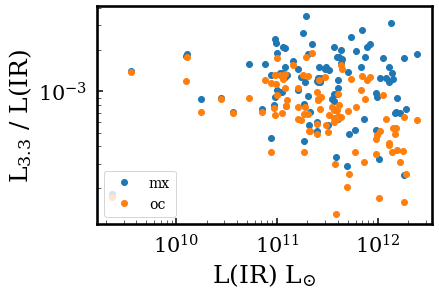

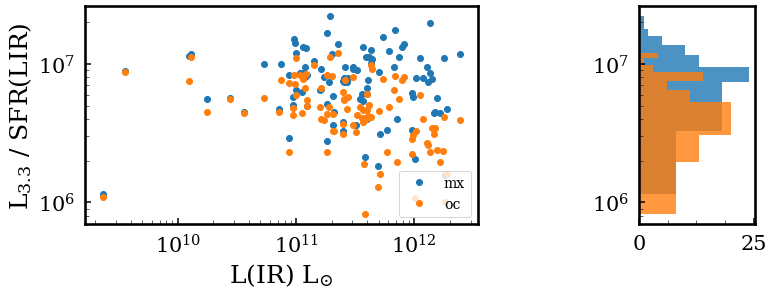

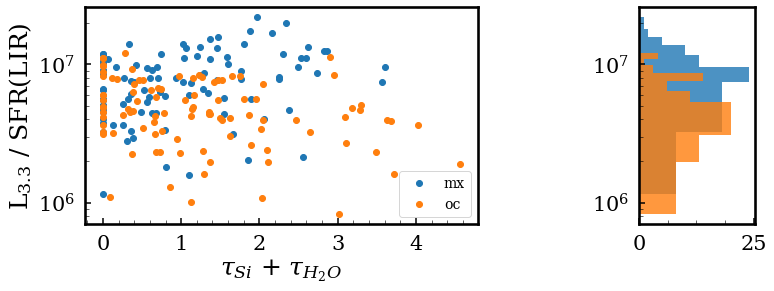

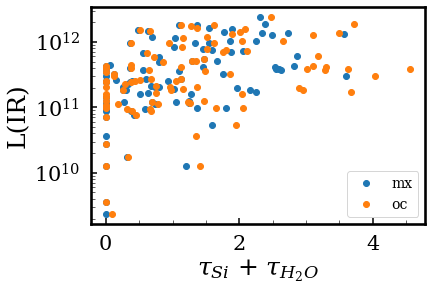

In [53]:
fig1 = plt.figure()
fig2 = plt.figure(figsize=(12,4))
fig3 = plt.figure(figsize=(12,4))
fig4 = plt.figure()

gs2 = fig2.add_gridspec(1, 5)
gs3 = fig3.add_gridspec(1, 5)


ax1 = fig1.add_subplot(111)
ax21, ax22 = fig2.add_subplot(gs2[0, 0:3]), fig2.add_subplot(gs2[0, 4])
ax31, ax32 = fig3.add_subplot(gs3[0, 0:3]), fig3.add_subplot(gs3[0, 4])
ax4 = fig4.add_subplot(111)

for mode in ['mx', 'oc']:

    df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
    
    ax1.plot(df.L_IR/const.L_sun.to('erg/s').value, df.L_f33 / df.L_IR, 'o', label=mode)
    
    ax21.plot(df.L_IR/const.L_sun.to('erg/s').value, df.L_f33/const.L_sun.to('erg/s').value / df.sf_LIR, 'o', label=mode)
    ax22.hist(df.L_f33/const.L_sun.to('erg/s').value / df.sf_LIR, orientation='horizontal', alpha=0.8)
    
    ax31.plot(df.tau_Si, df.L_f33/const.L_sun.to('erg/s').value / df.sf_LIR, 'o', label=mode)
    #ax31.plot(df.tau_Si+df.tau_H2O, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    ax32.hist(df.L_f33/const.L_sun.to('erg/s').value / df.sf_LIR, orientation='horizontal', alpha=0.8)
    
    ax4.plot(df.tau_Si, df.L_IR/const.L_sun.to('erg/s').value, 'o', label=mode)
    #ax4.plot(df.tau_Si+df.tau_H2O, df.L_Ne_comb/const.L_sun.to('erg/s').value, 'o', label=mode)
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'L(IR) L$_{\odot}$')
    ax1.set_ylabel(r'L$_\mathrm{3.3}$ / L(IR)')
    ax1.legend(loc=3, fontsize=14)
    
    ax21.set_xscale('log')
    ax21.set_yscale('log')
    ax21.set_xlabel(r'L(IR) L$_{\odot}$')
    ax21.set_ylabel(r'L$_\mathrm{3.3}$ / SFR(LIR)')
    ax21.legend(loc=4, fontsize=14)
    
    ax22.set_yscale('log')
    
    ax31.set_yscale('log')
    ax31.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
    ax31.set_ylabel(r'L$_\mathrm{3.3}$ / SFR(LIR)')
    ax31.legend(loc=4, fontsize=14)
    
    ax32.set_yscale('log')
    
    ax4.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
    ax4.set_ylabel('L(IR)')
    #ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.legend(loc=4, fontsize=14)

# Test how 3.3 um PAH and Br$\alpha$ correlates with SFR

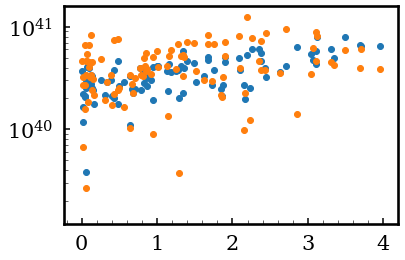

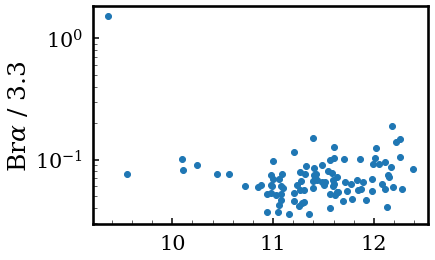

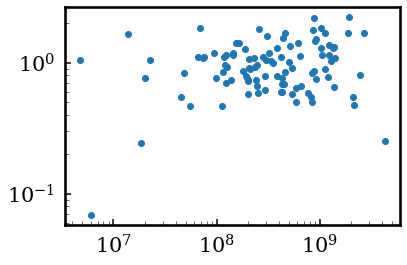

In [84]:
# Read SFR .pkl files
sc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/sc_SFR.pkl")
oc = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/oc_SFR.pkl")
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/mx_SFR.pkl")

df = mx

plt.figure()
for sfri in [ 'sf_Ne', 'sf_Halpha_S24']:
    plt.scatter(df.tau_Si + df.tau_H2O, df.L_f33/df[sfri])
#plt.scatter(df.tau_Si + df.tau_H2O, df.L_f33/df.sf_LIR, color='r')

#plt.xscale('log')
plt.yscale('log')







plt.figure()
plt.plot(df.log_LIR, df.L_Br_alpha / df.L_f33, 'o')
plt.ylabel(r'Br$\alpha$ / 3.3')
#plt.xscale('log')
plt.yscale('log')
# df = mx 

plt.figure()
plt.plot(df.L_Ne_comb/const.L_sun.to('erg/s').value, df.L_f33 / df.L_Ne_comb, 'o')
plt.xscale('log')
plt.yscale('log')



### Even though 3.3 PAH and Br$\alpha$ are closely located in the spectrum, the ratio of Br$\alpha$ to 3.3 PAH changes as LIR increases.

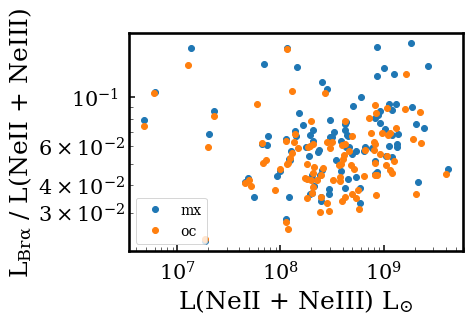

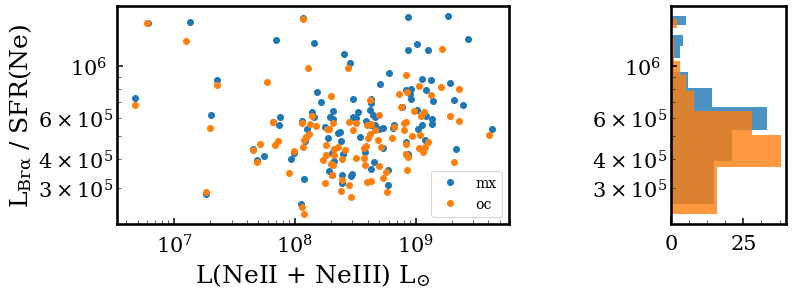

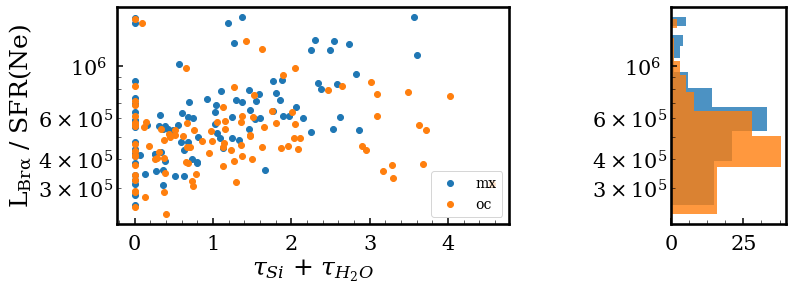

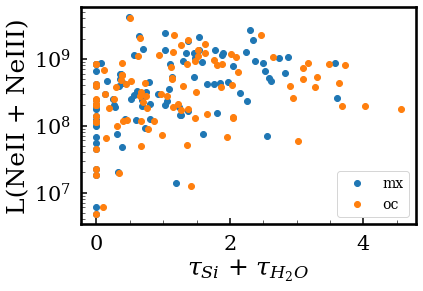

In [50]:
fig1 = plt.figure()
fig2 = plt.figure(figsize=(12,4))
fig3 = plt.figure(figsize=(12,4))
fig4 = plt.figure()

gs2 = fig2.add_gridspec(1, 5)
gs3 = fig3.add_gridspec(1, 5)


ax1 = fig1.add_subplot(111)
ax21, ax22 = fig2.add_subplot(gs2[0, 0:3]), fig2.add_subplot(gs2[0, 4])
ax31, ax32 = fig3.add_subplot(gs3[0, 0:3]), fig3.add_subplot(gs3[0, 4])
ax4 = fig4.add_subplot(111)

for mode in ['mx', 'oc']:

    df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
    
    ax1.plot(df.L_Ne_comb/const.L_sun.to('erg/s').value, df.L_Br_alpha / df.L_Ne_comb, 'o', label=mode)
    
    ax21.plot(df.L_Ne_comb/const.L_sun.to('erg/s').value, df.L_Br_alpha/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    ax22.hist(df.L_Br_alpha/const.L_sun.to('erg/s').value / df.sf_Ne, orientation='horizontal', alpha=0.8)
    
    ax31.plot(df.tau_Si, df.L_Br_alpha/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    #ax31.plot(df.tau_Si+df.tau_H2O, df.L_Br_alpha/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    ax32.hist(df.L_Br_alpha/const.L_sun.to('erg/s').value / df.sf_Ne, orientation='horizontal', alpha=0.8)
    
    ax4.plot(df.tau_Si, df.L_Ne_comb/const.L_sun.to('erg/s').value, 'o', label=mode)
    #ax4.plot(df.tau_Si+df.tau_H2O, df.L_Ne_comb/const.L_sun.to('erg/s').value, 'o', label=mode)
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'L(NeII + NeIII) L$_{\odot}$')
    ax1.set_ylabel(r'L$_\mathrm{Br\alpha}$ / L(NeII + NeIII)')
    ax1.legend(loc=3, fontsize=14)
    
    ax21.set_xscale('log')
    ax21.set_yscale('log')
    ax21.set_xlabel(r'L(NeII + NeIII) L$_{\odot}$')
    ax21.set_ylabel(r'L$_\mathrm{Br\alpha}$ / SFR(Ne)')
    ax21.legend(loc=4, fontsize=14)
    
    ax22.set_yscale('log')
    
    ax31.set_yscale('log')
    ax31.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
    ax31.set_ylabel(r'L$_\mathrm{Br\alpha}$ / SFR(Ne)')
    ax31.legend(loc=4, fontsize=14)
    
    ax32.set_yscale('log')
    
    ax4.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
    ax4.set_ylabel('L(NeII + NeIII)')
    #ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.legend(loc=4, fontsize=14)

# The ratio fo 3.3 / Br$\alpha$ as a function of $\tau$

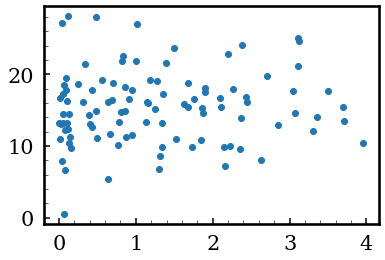

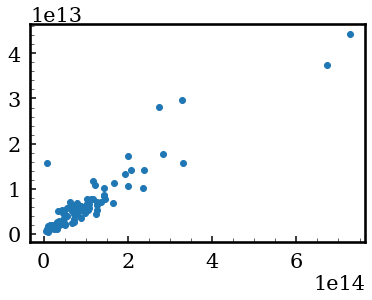

In [52]:
plt.figure()
plt.plot(mx.tau_H2O+mx.tau_Si, mx.f33/mx.Br_alpha_strength, 'o')

plt.figure()
plt.plot(mx.f33, mx.Br_alpha_strength, 'o')

In [45]:
mx.columns

Index(['Br_alpha_strength', 'Br_alpha_strength_unc', 'GOALS_target',
       'NeIII_strength', 'NeIII_strength_unc', 'NeII_strength',
       'NeII_strength_unc', 'akari_color', 'conti27', 'conti43', 'dfwhm12',
       'dfwhm6', 'f113', 'f113_unc', 'f17', 'f17_unc', 'f33', 'f33_fwhm',
       'f33_unc', 'f33ew', 'f34', 'f347', 'f347_fwhm', 'f347_unc', 'f34_fwhm',
       'f34_unc', 'f62', 'f62_unc', 'f62ew', 'f77', 'f77_unc', 'f83',
       'f83_unc', 'f86', 'f86_unc', 'fwhm_H2O', 'hot_grains', 'irc_id',
       'log_LIR', 'mirclass', 'pah62_eqw_err_ideos', 'pah62_eqw_ideos',
       'phase', 'snr_at33', 'target', 'tau_H2O', 'tau_Si', 'tau_Si_ideos',
       'tot_pah', 'tot_pah_unc', 'vsg', 'z', 'S24', 'S24_snr', 'S24_unc',
       'S24_color', 'L_f33', 'L_f34', 'L_f347', 'L_f62', 'L_f77', 'L_f83',
       'L_f86', 'L_f113', 'L_f17', 'L_tot_pah', 'L_NeII', 'L_NeII_unc',
       'L_NeIII', 'L_NeIII_unc', 'L_Br_alpha', 'L_Br_alpha_unc', 'L_S24',
       'L_S24_unc', 'L_IR', 'nsum', 'nsum_int', 'conti

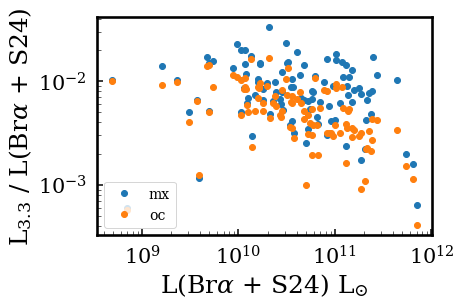

In [45]:
plt.figure()
for mode in ['mx', 'oc']:

    df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
    
    plt.plot((df.L_Br_alpha + df.L_S24)/const.L_sun.to('erg/s').value, df.L_f33 / (df.L_Br_alpha + df.L_S24), 'o', label=mode)
    #plt.plot((df.L_Br_alpha)/const.L_sun.to('erg/s').value, df.L_f33 / (df.L_Br_alpha), 'o', label=mode)
    #plt.plot(df.sf_Halpha_S24, df.L_f33 / df.sf_Halpha_S24, 'o', label=mode)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'L(Br$\alpha$ + S24) L$_{\odot}$')
plt.ylabel(r'L$_\mathrm{3.3}$ / L(Br$\alpha$ + S24)')
plt.legend(loc=3, fontsize=14)




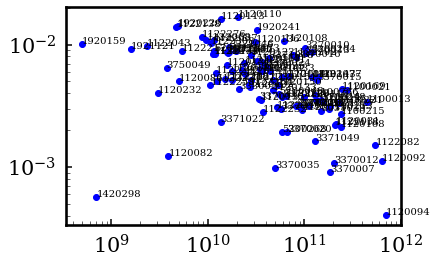

In [132]:
ax = pcs.plotlabel((df.L_Br_alpha + df.L_S24)/const.L_sun.to('erg/s').value, df.L_f33 / (df.L_Br_alpha + df.L_S24), df.irc_id)
ax.set_xscale('log')
ax.set_yscale('log')

before 3-sigma clipping -- number: 102
after 3-sigma clipping -- number: 98
median: 0.800
mean: 0.827
std: 0.262
before 3-sigma clipping -- number: 102
after 3-sigma clipping -- number: 88
median: 0.125
mean: 0.150
std: 0.075


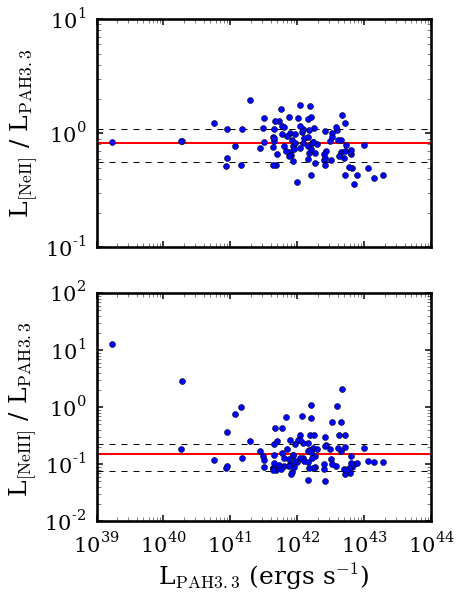

In [327]:
from astropy.stats import sigma_clip

df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fs_SFR.pkl")

fig = plt.figure(num=1, figsize=(6,9))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax.plot(df.L_f33, df.L_NeII/df.L_f33, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'L$\mathrm{_{[NeII]}}$ / L$\mathrm{_{PAH3.3}}$')
ax.set_xticklabels([])

r = df.L_NeII/df.L_f33
print("before 3-sigma clipping -- number: {:.0f}".format(len(r)))
filter_data = sigma_clip(r, sigma=3)
r = r[~filter_data.mask]
print("after 3-sigma clipping -- number: {:.0f}".format(len(r)))
med = np.median(r)
mean = np.mean(r)
std = np.std(r)

print("median: {:.3f}".format(med))
print("mean: {:.3f}".format(mean))
print("std: {:.3f}".format(std))

ax.hlines(mean, xmin=1E39, xmax=1E44, linewidth=2, color='r')
ax.hlines(mean+std, xmin=1E39, xmax=1E44, linewidth=1, color='k', linestyle='--')
ax.hlines(mean-std, xmin=1E39, xmax=1E44, linewidth=1, color='k', linestyle='--')

# -----------------------------------------------------------------
ax2.plot(df.L_f33, df.L_NeIII/df.L_f33, 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel(r'L$\mathrm{_{[NeIII]}}$ / L$\mathrm{_{PAH3.3}}$ ')
ax2.set_xlabel(r'L$\mathrm{_{PAH3.3}}$ (ergs s$^{-1}$)')

r = df.L_NeIII/df.L_f33
print("before 3-sigma clipping -- number: {:.0f}".format(len(r)))
filter_data = sigma_clip(r, sigma=3)
r = r[~filter_data.mask]
print("after 3-sigma clipping -- number: {:.0f}".format(len(r)))
med = np.median(r)
mean = np.mean(r)
std = np.std(r)

print("median: {:.3f}".format(med))
print("mean: {:.3f}".format(mean))
print("std: {:.3f}".format(std))

ax2.hlines(mean, xmin=1E39, xmax=1E44, linewidth=2, color='r')
ax2.hlines(mean+std, xmin=1E39, xmax=1E44, linewidth=1, color='k', linestyle='--')
ax2.hlines(mean-std, xmin=1E39, xmax=1E44, linewidth=1, color='k', linestyle='--')

plt.subplots_adjust(wspace=0.01)

In [345]:
df.columns

Index(['Br_alpha_strength', 'Br_alpha_strength_unc', 'GOALS_target',
       'NeIII_strength', 'NeIII_strength_unc', 'NeII_strength',
       'NeII_strength_unc', 'akari_color', 'conti27', 'conti43', 'dfwhm12',
       'dfwhm6', 'f113', 'f113_unc', 'f170', 'f170_unc', 'f33', 'f33_fwhm',
       'f33_unc', 'f33ew', 'f34', 'f345', 'f345_fwhm', 'f345_unc', 'f34_fwhm',
       'f34_unc', 'f62', 'f62_unc', 'f62ew', 'f77', 'f77_unc', 'f83',
       'f83_unc', 'f86', 'f86_unc', 'fwhm_H2O', 'irc_id', 'log_lir',
       'mirclass', 'pah62_eqw_err_ideos', 'pah62_eqw_ideos', 'phase',
       'snr_at33', 'target', 'tau_H2O', 'tau_Si', 'tau_Si_ideos', 'tot_pah',
       'tot_pah_unc', 'z', 'L_f33', 'L_f34', 'L_f345', 'L_f62', 'L_f77',
       'L_f83', 'L_f86', 'L_f113', 'L_f170', 'L_tot_pah', 'L_NeII',
       'L_NeII_unc', 'L_NeIII', 'L_NeIII_unc', 'L_Br_alpha', 'L_Br_alpha_unc',
       'S24', 'L_IR', 'L_Ne_comb', 'L_Ne_comb_unc', 'sf_Ne', 'sf_Ne_unc',
       'sf_Bra', 'sf_Bra_unc', 'sf_LIR', 'L_S24', 'sf_S2

num in fs: 102
num in fp: 102


RuntimeError: No active exception to reraise

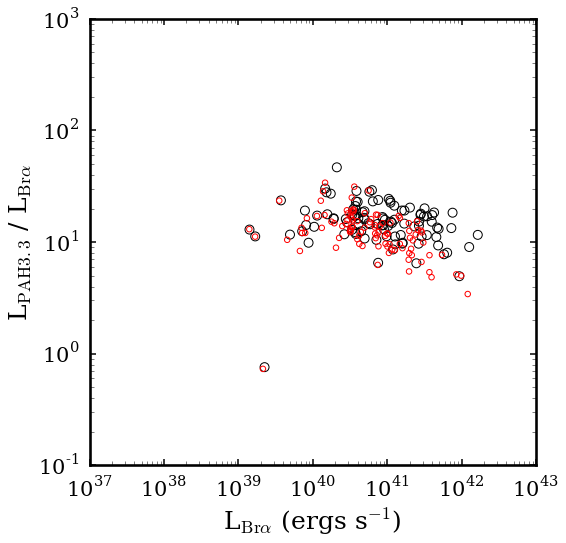

In [256]:
fig = plt.figure(figsize=(8,8))


ax = fig.add_subplot(111)
#ax.scatter(np.log10(df.L_NeII + df.L_NeIII), np.log10(df.L_f33 / (df.L_NeII + df.L_NeIII)), marker='o', edgecolor='k', facecolor='none', s=80)

df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fs_SFR.pkl")
print("num in fs: {:.0f}".format(len(df)))
#print("In fs: L_f33 / L_Ne_comb = {:.3f}".format(np.mean(df.L_f33 / (df.L_NeII + df.L_NeIII))))
ax.scatter(df.L_Br_alpha, df.L_f33 / df.L_Br_alpha, marker='o', edgecolor='k', facecolor='none', s=80, zorder=3)

df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fp_SFR.pkl")
print("num in fp: {:.0f}".format(len(df)))
ax.scatter(df.L_Br_alpha, df.L_f33 / df.L_Br_alpha, marker='o', edgecolor='r', facecolor='none', s=30, zorder=3)



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1E37, 1E43)
ax.set_ylim(1E-1, 1E3)

ax.set_xlabel(r'L$\mathrm{_{Br \alpha}}$ (ergs s$^{-1}$)')
ax.set_ylabel(r'L$\mathrm{_{PAH3.3}}$ / L$_{\mathrm{Br \alpha}}$')

raise
# xerr = df.L_Br_alpha_unc
# yerr = np.sqrt((df.f33_unc/df.f33)**2 + (df.L_Ne_comb_unc/df.L_Ne_comb)**2)
# ax.errorbar(df.L_Ne_comb, df.L_f33/df.L_Ne_comb, 
#             xerr=xerr.values, yerr=yerr.values, fmt='none', capsize=3, ecolor='gray', zorder=1)

#ax.hlines(np.mean(df.L_f33 / (df.L_NeII + df.L_NeIII)), xmin=1E39, xmax=1E45, linestyle='-', color='r', linewidth=2)

#ratio = df.L_f33/df.L_Ne_comb
#print("percentage of galaxy in between 0.5 and 1.5: {:.2f}".format(100*len(ratio[(ratio > 0.5) & (ratio < 1.5)]) / len(ratio)))

#df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fp_SFR.pkl")
#print("num in fp: {:.0f}".format(len(df)))
#ax.scatter(df.L_Ne_comb, df.L_f33 / df.L_Ne_comb, marker='o', edgecolor='b', facecolor='none', s=30, zorder=3)




IIZw40 = df[df.irc_id == '1420298']
ax.scatter(IIZw40.L_NeII + IIZw40.L_NeIII, IIZw40.L_f33 / (IIZw40.L_NeII + IIZw40.L_NeIII), marker='*', 
           edgecolor='k', facecolor='red', s=300, zorder=3)
ax.annotate('II Zw 40', xy=((IIZw40.L_NeII + IIZw40.L_NeIII)*1.1, IIZw40.L_f33 / (IIZw40.L_NeII + IIZw40.L_NeIII)*0.6))
ax.annotate('150%', xy=(3E43, 1.6), fontsize=14)
ax.annotate('100%', xy=(3E43, 0.8), fontsize=14)
ax.annotate('50%', xy=(3.6E43, 0.4), fontsize=14)
raise
print(np.mean(df.L_f33 / (df.L_NeII + df.L_NeIII)))

ax.hlines(np.mean(df.L_f33 / (df.L_NeII + df.L_NeIII)), xmin=1E39, xmax=1E45, linestyle='-', color='r', linewidth=2)
ax.hlines(1, xmin=1E39, xmax=1E45, linestyle='dashed')
ax.hlines(1.5, xmin=1E39, xmax=1E45, linestyle='dashed')
ax.hlines(0.5, xmin=1E39, xmax=1E45, linestyle='dashed')
ax.set_xlabel(r'L$\mathrm{_{[NeII] + [NeIII]}}$ (ergs s$^{-1}$)')
ax.set_ylabel(r'L$\mathrm{_{PAH3.3}}$ / L$_{\mathrm{[NeII] + [NeIII]}}$')
ax.set_xlim(10E38, 10E43)
#ax.set_ylim(-2, 1)
fig.tight_layout()
#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/pah33_and_Ne.pdf')
# -------------------------------
pcs.plotlabel(np.log10(df.L_NeII + df.L_NeIII), np.log10(df.L_f33 / (df.L_NeII + df.L_NeIII)), df.irc_id)
#fig.gca().set_aspect('equal')
# -------------------------------

(0, 4)

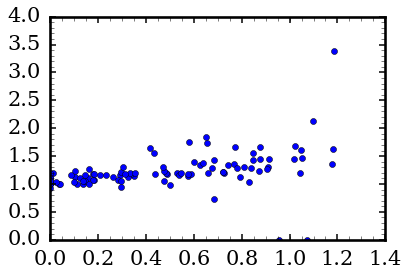

In [274]:
fs = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fs_SFR.pkl")
fp = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/fp_SFR.pkl")

a = fs.merge(fp, on='irc_id')
# calculate the ration of pah33 / Br alpha
a['r_fs'] = a.L_f33_x / a.L_Br_alpha_x
a['r_fp'] = a.L_f33_y / a.L_Br_alpha_y
plt.figure()

plt.plot(a.tau_Si_x, a.r_fs/a.r_fp, 'o')
plt.ylim(0,4)

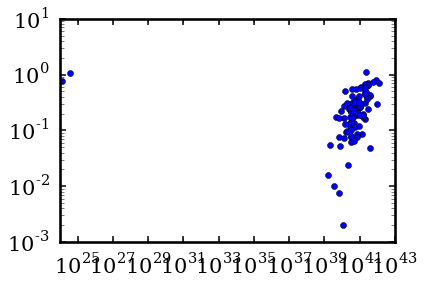

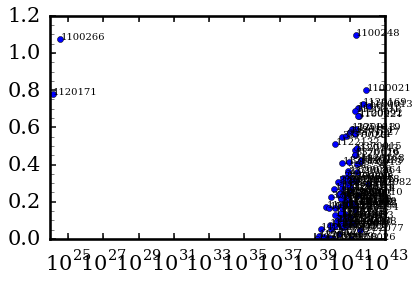

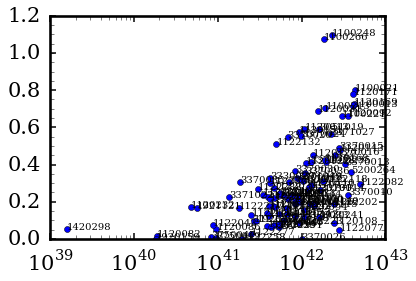

In [280]:
plt.figure()
plt.plot(fp.L_Br_alpha, fp.tau_H2O, 'o')
plt.xscale('log')
plt.yscale('log')

ax = pcs.plotlabel(fp.L_Br_alpha, fp.tau_H2O, fp.irc_id)
ax.set_xscale('log')
#ax.set_yscale('log')

#fp.sort_values(['L_Br_alpha']).irc_id
ax = pcs.plotlabel(fp.L_f33, fp.tau_H2O, fp.irc_id)
ax.set_xscale('log')

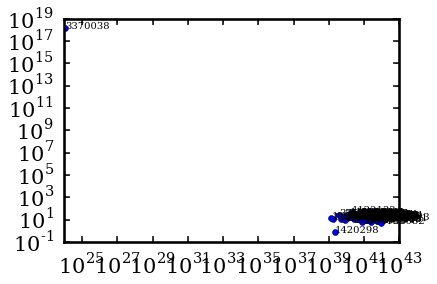

In [247]:
ax = pcs.plotlabel(df.L_Br_alpha, df.L_f33/df.L_Br_alpha, df.irc_id)
ax.set_xscale('log')
ax.set_yscale('log')

In [244]:
print(df[df.irc_id == '3370038'].L_Br_alpha)
print(df[df.irc_id == '3370038'].L_f33)

109    1.124913e+24
Name: L_Br_alpha, dtype: float64
109    1.602088e+42
Name: L_f33, dtype: float64


In [87]:
df.columns

Index(['Br_alpha_strength', 'Br_alpha_strength_unc', 'GOALS_target',
       'NeIII_strength', 'NeIII_strength_unc', 'NeII_strength',
       'NeII_strength_unc', 'akari_color', 'conti27', 'conti43', 'dfwhm12',
       'dfwhm6', 'f113', 'f113_unc', 'f170', 'f170_unc', 'f33', 'f33_fwhm',
       'f33_unc', 'f33ew', 'f34', 'f345', 'f345_fwhm', 'f345_unc', 'f34_fwhm',
       'f34_unc', 'f62', 'f62_unc', 'f62ew', 'f77', 'f77_unc', 'f83',
       'f83_unc', 'f86', 'f86_unc', 'fwhm_H2O', 'irc_id', 'log_lir',
       'mirclass', 'pah62_eqw_err_ideos', 'pah62_eqw_ideos', 'phase',
       'snr_at33', 'target', 'tau_H2O', 'tau_Si', 'tau_Si_ideos', 'tot_pah',
       'tot_pah_unc', 'z', 'L_f33', 'L_f34', 'L_f345', 'L_f62', 'L_f77',
       'L_f83', 'L_f86', 'L_f113', 'L_f170', 'L_tot_pah', 'L_NeII',
       'L_NeII_unc', 'L_NeIII', 'L_NeIII_unc', 'L_Br_alpha', 'L_Br_alpha_unc',
       'S24', 'L_IR', 'L_Ne_comb', 'L_Ne_comb_unc'],
      dtype='object')

correlation coef: 0.89


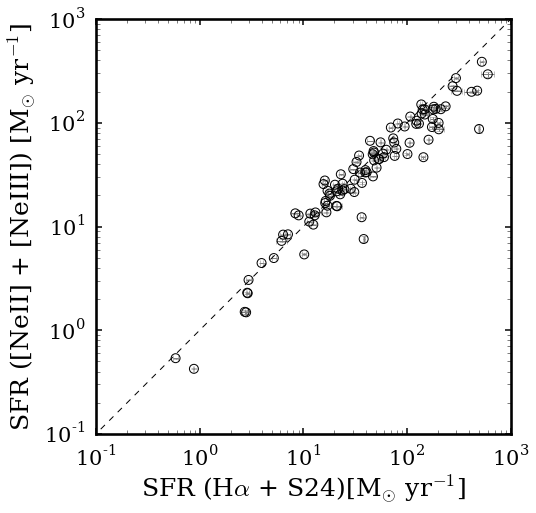

In [85]:
print("correlation coef: {:.2f}".format(np.corrcoef(df.sf_Halpha_S24, df.sf_Ne)[0,1]))
np.std(df.sf_Halpha_S24/df.sf_Ne)

fig = plt.figure(num=7, figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(df.sf_Halpha_S24, df.sf_Ne, marker='o', edgecolors='k', facecolors='none', zorder=3, s=80)
ax.errorbar(df.sf_Halpha_S24, df.sf_Ne, xerr=df.sf_Halpha_S24_unc.values, yerr=df.sf_Ne_unc.values,fmt='none', capsize=3, ecolor='gray')
ax.plot([0.01, 1000],[0.01,1000], color='k', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'SFR (H$\alpha$ + S24)[M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR ([NeII] + [NeIII]) [M$_{\odot}$ yr$^{-1}$]')
ax.set_xlim([0.1, 1000])
ax.set_ylim([0.1, 1000])
fig.gca().set_aspect('equal')
plt.tight_layout()
#fig.savefig('/Users/thomaslai/Documents/astro/PAH/PAH_pub_figure/SFR_Halpha+S24_Ne.pdf')

In [12]:
np.std(df.sf_Halpha_S24/df.sf_Ne)

0.7849785614112279

In [30]:
len(df)

101

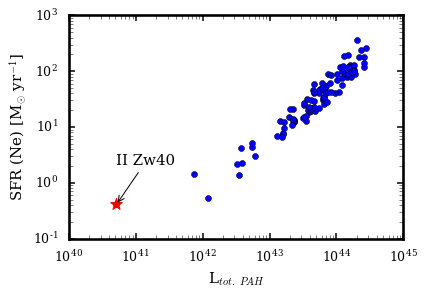

In [30]:
# Compare SF result with Xie et al. 2019

plt.figure()
plt.plot(df.L_tot_pah, df.sf_Ne,'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'L$_{tot. \ PAH}$')
plt.ylabel('SFR (Ne) [M$_{\odot}$ yr$^{-1}$]')

IIZw40 = df[df.L_tot_pah == df.L_tot_pah.min()]
plt.scatter(IIZw40.L_tot_pah, IIZw40.sf_Ne, marker='*', s=150, zorder=3,
           color='r')

plt.annotate("II Zw40", xy=(IIZw40.L_tot_pah, IIZw40.sf_Ne),
            xytext=(IIZw40.L_tot_pah, IIZw40.sf_Ne*5),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            )


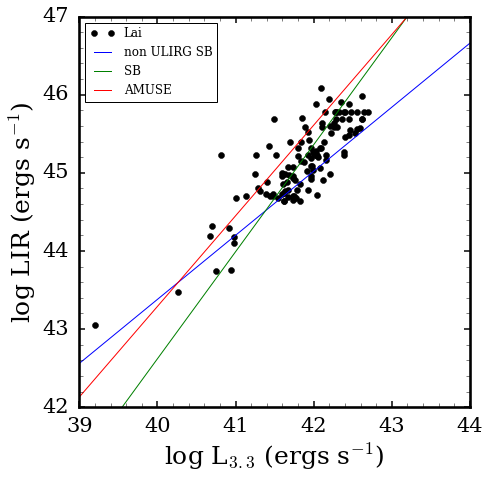

In [161]:
df = fp

fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111)
ax.plot(np.log10(df.L_f33), np.log10(10**df.log_lir * const.L_sun.value * 1E7), 'ko', label='Lai')
#ax.plot(x, y, 'k')

x = np.linspace(39, 44, 10)
y_nonULIRG = 0.82*x + 10.58
y_SB = 1.37*x - 12.18
y_AMUSE = 1.16*x - 3.11

ax.plot(x, y_nonULIRG, label='non ULIRG SB')
ax.plot(x, y_SB, label='SB')
ax.plot(x, y_AMUSE, label='AMUSE')
ax.set_xlabel(r'log L$_{3.3}$ (ergs s$^{-1}$)')
ax.set_ylabel(r'log LIR (ergs s$^{-1}$)')
ax.set_xlim(39, 44)
ax.set_ylim(42, 47)
ax.legend(fontsize=12, loc=2)
#fig.gca().set_aspect('equal')
# ------------------------


In [140]:
const.L_sun.value

3.828e+26

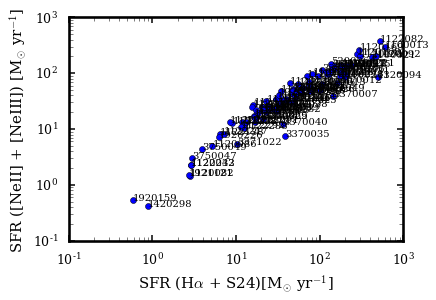

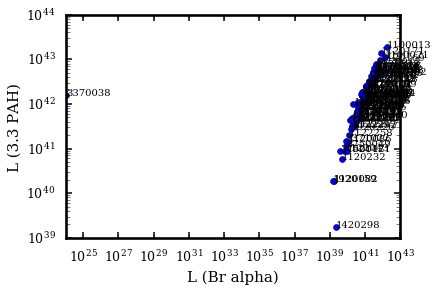

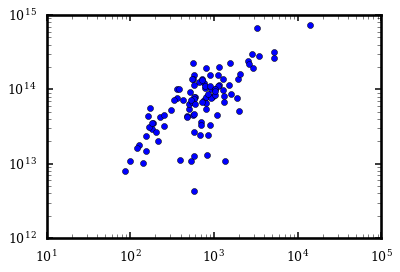

In [8]:
ax = pcs.plotlabel(df.sf_Halpha_S24, df.sf_Ne, df.irc_id)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'SFR (H$\alpha$ + S24)[M$_{\odot}$ yr$^{-1}$]')
ax.set_ylabel(r'SFR ([NeII] + [NeIII]) [M$_{\odot}$ yr$^{-1}$]')

ax = pcs.plotlabel(df.L_Br_alpha, df.L_f33, df.irc_id)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('L (Br alpha)')
ax.set_ylabel('L (3.3 PAH)')

plt.figure()
plt.plot(df.S24, df.f33,'o')
plt.xscale('log')
plt.yscale('log')

/Users/thomaslai/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/Users/thomaslai/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


1.4181952555946868

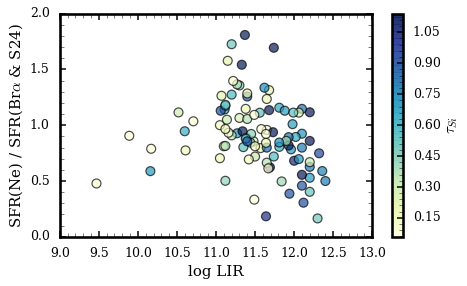

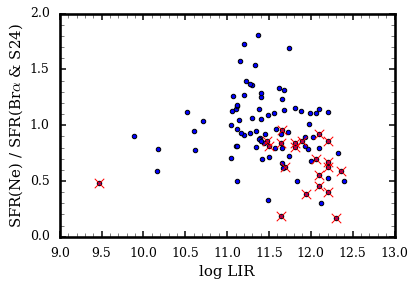

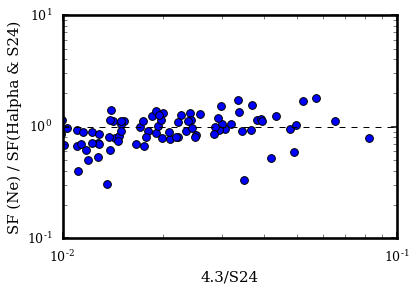

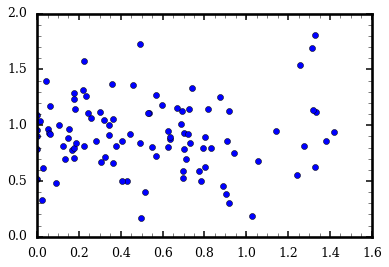

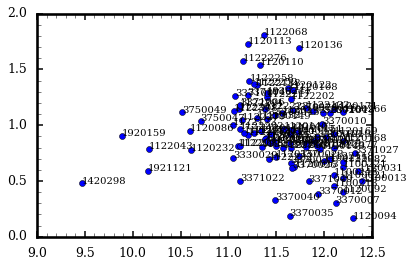

In [115]:
def scolorbar(x, y, c):
    plt.close(1) 
    fig = plt.figure(num=1, figsize=(7,4))
    ax = fig.add_subplot(111)
    
    cm = plt.cm.get_cmap('YlGnBu')#('viridis')
    color = c

    sc = ax.scatter(x, y, c=color,
                      s=80, cmap=cm, linewidth=1.2, 
                      vmin=np.nanpercentile(c, 10), vmax=np.nanpercentile(c, 90), alpha=0.7)

    cbar = fig.colorbar(sc)

    return ax, cbar

ax, cbar = scolorbar(df.log_lir, df.sf_Ne/df.sf_Halpha_S24, df.tau_Si)
ax.set_xlabel('log LIR')
ax.set_ylabel(r'SFR(Ne) / SFR(Br$\alpha$ & S24)')
cbar.ax.set_ylabel(r'$\tau _{Si}$')
#ax.set_yscale('log')
# ==============================================
df.conti27_to_S24 = df.conti27/df.S24 
df.conti43_to_S24 = df.conti43/df.S24 

plt.figure()
plt.scatter(df.log_lir, df.sf_Ne/df.sf_Halpha_S24)
red = df[df.conti27_to_S24 < 0.012]
plt.scatter(red.log_lir, red.sf_Ne/red.sf_Halpha_S24, marker='x', s=90, facecolor='r')
plt.xlabel('log LIR')
plt.ylabel(r'SFR(Ne) / SFR(Br$\alpha$ & S24)')
# ==============================================
plt.figure()
plt.scatter(df.conti43_to_S24, df.sf_Ne/df.sf_Halpha_S24, s=60)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('4.3/S24')
plt.ylabel('SF (Ne) / SF(Halpha & S24)')
plt.hlines(1, xmin=0.01, xmax=0.1, linestyle='dashed')
plt.xlim(0.01, 0.1)
# ==============================================
plt.figure()
plt.plot(df.tau_Si, df.sf_Ne/df.sf_Halpha_S24, 'o')


pcs.plotlabel(df.log_lir, df.sf_Ne/df.sf_Halpha_S24, df.irc_id)

np.max(df.tau_Si)



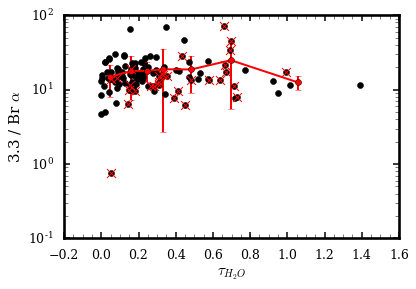

In [121]:
from matplotlib.gridspec import GridSpec
from scipy.stats import binned_statistic

df = fs

df['conti27_to_S24'] = df.conti27/df.S24 
df['conti43_to_S24'] = df.conti43/df.S24 
red = df[df.conti43_to_S24 < 0.012]

plt.figure()
plt.plot(df.tau_H2O, df.f33/df.Br_alpha_strength, 'ko')
plt.scatter(red.tau_H2O, red.f33/red.Br_alpha_strength, marker='x', facecolor='red', s=80, zorder=3)

new_df = pd.DataFrame({'x':df.tau_H2O, 'y':df.f33/df.Br_alpha_strength, 'irc_id':df.irc_id})
new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['y'], how="all")
new_df = new_df[new_df.y < 100]

x = new_df.x.values
y = new_df.y.values

n_bins = [0., 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.4]
bin_centers, _, _ = binned_statistic(x, x,
                                    statistic='mean',
                                    bins=n_bins)
bin_averages, _, _ = binned_statistic(x, y,
                                    statistic='mean',
                                    bins=n_bins)
bin_stdevs, _, _ = binned_statistic(x, y,
                                    statistic='std',
                                    bins=n_bins)

plt.errorbar(bin_centers, bin_averages, bin_stdevs,
           fmt='o-', color='r', linewidth=2, elinewidth=2)




plt.ylim(0.1,100)
plt.xlabel(r'$\tau _{H_{2}O}$')
plt.ylabel(r'3.3 / Br $\alpha$')
plt.yscale('log')



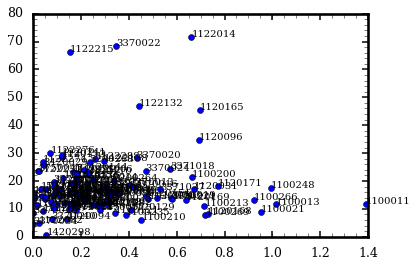

In [111]:
#df = df.dropna(subset=['f33', 'Br_alpha_strength'])
pcs.plotlabel(new_df.x, new_df.y, new_df.irc_id)

In [108]:
new_df.columns

Index(['x', 'y', 'ratio'], dtype='object')

/Users/thomaslai/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


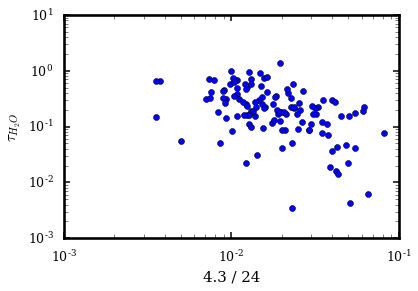

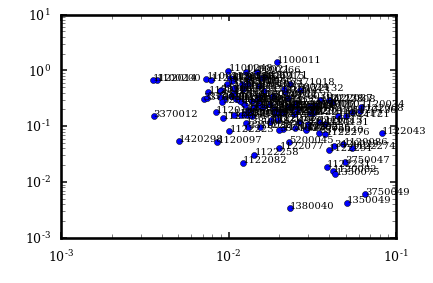

In [50]:
plt.figure()
plt.plot(df.conti43_to_S24, df.tau_H2O, 'o')
#plt.scatter(red.conti43_to_S24, red.tau_H2O, marker='x', facecolor='red', s=80, zorder=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('4.3 / 24')
plt.ylabel(r'$\tau _{H_{2}O}$')

ax = pcs.plotlabel(df.conti43_to_S24, df.tau_H2O, df.irc_id)
ax.set_xscale('log')
ax.set_yscale('log')

In [99]:
df.ratio

0      1.170440e+01
1      1.160899e+01
2      9.035773e+00
3      8.634709e+00
4      2.159877e+01
5      6.180201e+00
6      1.110336e+01
7      1.739018e+20
8      1.349605e+01
9      7.781047e+00
10     1.746294e+01
11     1.313654e+01
12     7.677915e+00
13     1.382926e+01
14     1.702031e+01
15     2.736363e+02
16     1.124334e+01
17     1.371095e+01
18     1.154607e+01
19     6.458884e+00
20     3.459410e+01
21     1.374377e+01
22     1.523914e+01
23     1.412171e+01
24     1.918022e+01
25     2.253109e+01
26     2.872410e+01
27     9.689638e+00
28     1.161726e+02
29     2.316202e+01
           ...     
98     2.828325e+01
99     6.851427e+01
100    1.587512e+01
101    2.344301e+01
102    1.122229e+01
103    8.594733e+00
104    1.483033e+01
105    1.395819e+01
106    4.693867e+00
107    1.286611e+01
108    1.630898e+01
109    1.424189e+18
110    6.524072e+00
111             inf
112    2.310982e+01
113    1.965899e+01
114    2.441128e+01
115    1.917324e+01
116    1.696067e+01


In [45]:
df = fs

df.conti27_to_S24 = df.conti27/df.S24 
df.conti43_to_S24 = df.conti43/df.S24 
red = df[df.conti43_to_S24 < 0.012]

In [66]:
y

array([ 11.70440471,  11.60898617,   9.03577275,   8.63470913,
        21.59876981,   6.18020083,  11.10335835,  13.49605366,
         7.78104716,  17.46294216,  13.13653999,   7.67791452,
        13.82925662,  17.02030895,  11.24333642,  13.71094817,
        11.54606738,   6.45888399,  34.5941044 ,  13.74377162,
        15.23914432,  14.12170726,  19.18022314,  22.53108598,
        28.72410409,   9.68963794,  23.16202104,   9.67470295,
        17.25430877,  17.5922168 ,  13.0516688 ,  12.50524681,
        21.20313801,  11.57768664,  16.76593252,  17.57255624,
        23.84339053,  21.03757836,  10.77620989,  14.15798045,
        14.64196856,  45.42396074,   8.03652185,  13.34932072,
        18.34002486,  13.60844778,  11.67281361,  71.71979685,
        18.50877561,  12.50897784,  16.00465633,   9.33401268,
         4.94481885,  16.10337742,  11.2260934 ,  46.77328368,
        27.16117138,  14.45412093,  19.17422439,  66.37015152,
        19.5165703 ,  16.3436111 ,  14.53878841,  23.42

# Test the difference between the break out of H$\alpha$ and Br$\alpha$

Start with COO (Calzetti Law), which assume a fixed Rv = 4.05 and a defined range in between 0.63 and 2.2 µm. \
Since we are comparing Br$\alpha$ with H$\alpha$, the upper limit of the wavelength should be extended to 4.05 µm. \
For the sake of simplicity, fit the attinuation curve with a linear line and extrapolate to the point. 

Text(0, 0.5, 'A(x)')

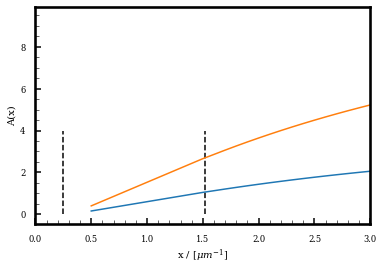

In [76]:
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling import models, fitting
import astropy.units as u
from scipy.interpolate import interp1d
from dust_attenuation.averages import C00

att_model_1 = C00(Av=1.3)
att_model_2 = C00(Av=3.3)
x = np.arange(0.5, 8.0, 0.1)/u.micron
# Convert to microns
w = 1/x


plt.figure()
plt.plot(x, att_model_1(w), label='Av=5')
plt.plot(x, att_model_2(w), label='Av=10')

plt.tick_params(which='both', direction='in')
plt.vlines(1/4.05, ymin=0, ymax=4, linestyle='--')
plt.vlines(1/0.6563, ymin=0, ymax=4, linestyle='--')
plt.xlim(0,3)
plt.xlabel(r'x / [$\mu m^{-1}$]')
plt.ylabel('A(x)')

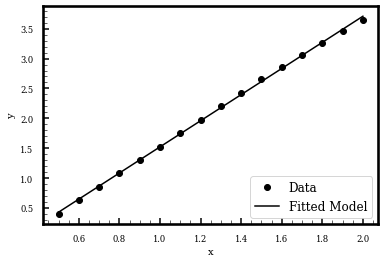

In [77]:
att_model = att_model_2

xx = x.value
xx = xx[xx < 2]
yy = att_model(1/xx)

# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line = fit(line_init, xx, yy)

# plot the model
plt.figure()
plt.plot(xx, yy, 'ko', label='Data')
plt.plot(xx, fitted_line(xx), 'k-', label='Fitted Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=4, fontsize=12)

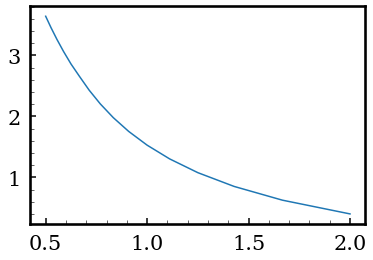

In [107]:
plt.figure()
plt.plot(1/xx, yy)

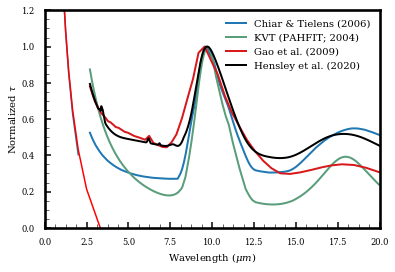

In [83]:
new_x = np.arange(0.1, 5, 0.1)
att_linear = new_x * fitted_line.slope + fitted_line.intercept

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(1/xx, yy)
ax.plot(1/new_x, att_linear, 'r')
ax.set_xlim(0, 20)
ax.set_ylim(0, 1.5)

# -------------------------
path = '/Users/thomaslai/Documents/astro/PAH/fitter_profile/'
# Chier & Tielens 2006
ct = pd.read_csv(path+'Chiar+Tielens_2005.txt',delim_whitespace=True,names=['wav','f'])
# Kemper
kvt = pd.read_csv(path+'kvt_beta_eq_0.1.txt',delim_whitespace=True,names=['wav','f'])
# Wang 2015
wang = pd.read_csv(path+'mir_1.2um_137ppm_extinction.txt',delim_whitespace=True,names=['wav','f'])
wang = pd.DataFrame({'wav':1/wang.wav, 'f':wang.f})

# Hensley 2020
hensley = pd.read_table(path+'alam_ak_apj_v1.dat', delim_whitespace=True, names=['wav','f'], comment='#')

#ct = ct[(ct.wav > 2.5) & (ct.wav < 38)]
#kvt = kvt[(kvt.wav > 2.5) & (kvt.wav < 38)]
#wang = wang[(wang.wav > 2.5) & (wang.wav < 38)]

interp_w = np.linspace(2.7,29,2640,endpoint=True)
#for ext in [ct,kvt,wang]:
f = interp1d(ct.wav, ct.f)
ct = pd.DataFrame({'wav': interp_w, 'f':f(interp_w)})

f = interp1d(kvt.wav, kvt.f)
kvt = pd.DataFrame({'wav': interp_w, 'f':f(interp_w)})

f = interp1d(wang.wav, wang.f)
wang = pd.DataFrame({'wav': interp_w, 'f':f(interp_w)})

f = interp1d(hensley.wav, hensley.f)
hensley = pd.DataFrame({'wav': interp_w, 'f':f(interp_w)})

#plt.close(4)
#fig4 = plt.figure(4)
#ax = fig4.add_subplot(111)
ax.plot(ct.wav, ct.f/np.max(ct[ct.wav > 8].f.values), label='Chiar & Tielens (2006)', color='#1f78b4', linewidth=2)
ax.plot(kvt.wav, kvt.f/np.max(kvt[kvt.wav > 8].f.values), label='KVT (PAHFIT; 2004)', color="#599d7A", linewidth=2)
ax.plot(wang.wav, wang.f/np.max(wang[wang.wav > 8].f.values), label='Gao et al. (2009)', color='#d7191c', linewidth=2)
ax.plot(hensley.wav, hensley.f/np.max(hensley[hensley.wav > 8].f.values), label='Hensley et al. (2020)', color='k', linewidth=2)

# tau = wang.f/np.max(wang[wang.wav > 8].f.values)
# ax.plot(wang.wav, np.exp(-tau), label='Gao et al. (2009) - screen', color='#d7191c', linewidth=2)
# ax.plot(wang.wav, (1-np.exp(-tau))/tau, label='Gao et al. (2009) - mixed', color="#599d7A", linewidth=2)


ax.set_ylim([0,1.2])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized $\tau$')
ax.legend(loc=0, frameon=False, fontsize=10)

In [90]:
# [NeII]: 12.81 um
# [NeIII]: 15.55 um

kvt_NeII = kvt[(kvt.wav > 12.8) & (kvt.wav < 12.82)].f.mean()
kvt_NeIII = kvt[(kvt.wav > 15.54) & (kvt.wav < 15.56)].f.mean()

hensley_NeII = hensley[(hensley.wav > 12.8) & (hensley.wav < 12.82)].f.mean()
hensley_NeIII = hensley[(hensley.wav > 15.54) & (hensley.wav < 15.56)].f.mean()

f_NeII = hensley_NeII / kvt_NeII
f_NeIII = hensley_NeIII / kvt_NeIII

print(f_NeII, f_NeIII)



2.8434071552654157 2.1273001435886068


In [111]:
def att_multiplier(tau, kvt, hensley):
    """
    INPUT: 
        tau - PAHFT result of the silicate optical depth using kvt attenuation profile.
        kvt - kvt profile
        hensley - Hensley profile
    OUTPUT: 
        the two ratios of the attenuation imposed on kvt and Hensley at [NeII] and [NeIII] lambda
    """
    ratio = pd.DataFrame({
                'wav': kvt.wav,
                'r': (1-np.exp(-kvt.f*tau))/(kvt.f*tau) / ((1-np.exp(-hensley.f*tau))/(hensley.f*tau))
                        }) 
    
    f_NeII = ratio[(ratio.wav > 12.8) & (hensley.wav < 12.82)].r.mean()
    f_NeIII = ratio[(ratio.wav > 15.54) & (ratio.wav < 15.56)].r.mean()
    
    return (f_NeII, f_NeIII)

(1.1289193910495472, 1.109459034738981)

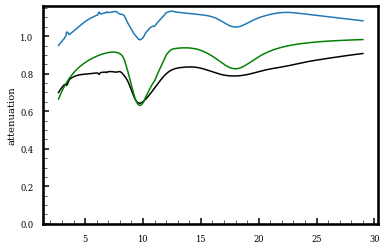

In [113]:
plt.figure()

tau = 1
plt.plot(hensley.wav, (1-np.exp(-hensley.f*tau))/(hensley.f*tau), 'k', label='Hensley')
plt.plot(kvt.wav, (1-np.exp(-kvt.f*tau))/(kvt.f*tau), 'g', label='KVT')

ratio = (1-np.exp(-kvt.f*tau))/(kvt.f*tau) / ((1-np.exp(-hensley.f*tau))/(hensley.f*tau))

plt.plot(kvt.wav, ratio)
plt.ylim(bottom=0)
plt.ylabel('attenuation')

att_multiplier(tau, kvt, hensley)

# Check how the whale diagram changes applying attenuation profile from Hensley et al. 2020

0
1


(array([ 1.,  0.,  0.,  4.,  5., 63., 22.,  4.,  2.,  1.]),
 array([0.57208669, 0.62529935, 0.67851202, 0.73172469, 0.78493736,
        0.83815003, 0.8913627 , 0.94457537, 0.99778804, 1.05100071,
        1.10421338]),
 <a list of 10 Patch objects>)

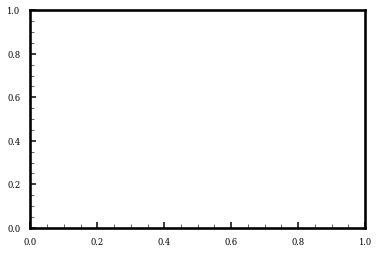

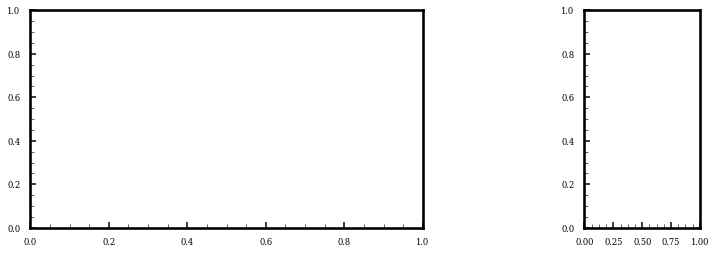

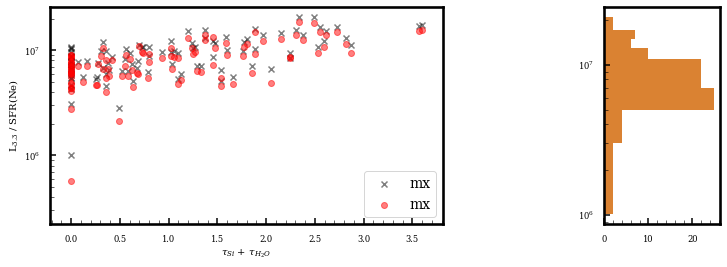

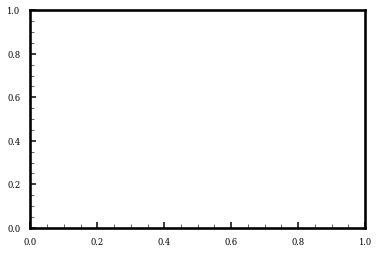

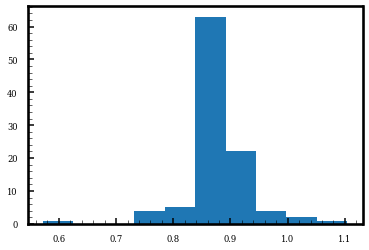

In [135]:
fig1 = plt.figure()
fig2 = plt.figure(figsize=(12,4))
fig3 = plt.figure(figsize=(12,4))
fig4 = plt.figure()

gs2 = fig2.add_gridspec(1, 5)
gs3 = fig3.add_gridspec(1, 5)


ax1 = fig1.add_subplot(111)
ax21, ax22 = fig2.add_subplot(gs2[0, 0:3]), fig2.add_subplot(gs2[0, 4])
ax31, ax32 = fig3.add_subplot(gs3[0, 0:3]), fig3.add_subplot(gs3[0, 4])
ax4 = fig4.add_subplot(111)

#for mode in ['mx']:

mode = 'mx'
df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")

for round in [0, 1]:
    print(round)
    if round == 1:
        # Estimate L_Ne using Hensley's attenuation profile
        f_NeII_list = []
        f_NeIII_list = []
        for i in np.arange(len(df.tau_Si)):
            f_NeII, f_NeIII = att_multiplier(df.tau_Si.iloc[i], kvt, hensley)
            f_NeII_list.append(f_NeII)
            f_NeIII_list.append(f_NeIII)

        df['L_NeII'] = f_NeII * df.L_NeII
        df['L_NeIII'] = f_NeIII * df.L_NeIII
        df['L_Ne_comb'] = df.L_NeII + df.L_NeIII

        cf_SaltoKro = 0.66 # conversion factor Salpeter --> Kroupa
        # SFR derived from Ne assuming Hensley attunuation profile
        df['sf_Ne_Hen'] = 4.34E-41 * (df.L_NeII + df.L_NeIII) / (f1 + 1.67*f2) * cf_SaltoKro #Zhuang 2019. Conversion from the Salpeter IMF to the Kroupa IMF by multiply 0.66 (Madau 2014)
        df['sf_Ne_unc'] = 4.34E-41 * df.L_Ne_comb_unc / (f1 + 1.67*f2) * cf_SaltoKro
        

#     ax1.plot(df.L_Ne_comb/const.L_sun.to('erg/s').value, df.L_f33 / df.L_Ne_comb, 'o', label=mode)

#     ax21.plot(df.L_Ne_comb/const.L_sun.to('erg/s').value, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
#     ax22.hist(df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, orientation='horizontal', alpha=0.8)

    if round == 0:
        c = 'k'
        m = 'x'
        ax31.scatter(df.tau_Si, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, marker=m, c=c, label=mode, alpha=0.5)
    if round == 1:
        c = 'r'
        m = 'o'
        ax31.scatter(df.tau_Si, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne_Hen, marker=m, c=c, label=mode, alpha=0.5)

        #ax31.plot(df.tau_Si+df.tau_H2O, df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, 'o', label=mode)
    ax32.hist(df.L_f33/const.L_sun.to('erg/s').value / df.sf_Ne, orientation='horizontal', alpha=0.8)

#ax4.plot(df.tau_Si, df.L_Ne_comb/const.L_sun.to('erg/s').value, 'o', label=mode)
#ax4.plot(df.tau_Si+df.tau_H2O, df.L_Ne_comb/const.L_sun.to('erg/s').value, 'o', label=mode)

#     ax1.set_xscale('log')
#     ax1.set_yscale('log')
#     ax1.set_xlabel(r'L(NeII + NeIII) L$_{\odot}$')
#     ax1.set_ylabel(r'L$_\mathrm{3.3}$ / L(NeII + NeIII)')
#     ax1.legend(loc=3, fontsize=14)

#     ax21.set_xscale('log')
#     ax21.set_yscale('log')
#     ax21.set_xlabel(r'L(NeII + NeIII) L$_{\odot}$')
#     ax21.set_ylabel(r'L$_\mathrm{3.3}$ / SFR(Ne)')
#     ax21.legend(loc=4, fontsize=14)

#     ax22.set_yscale('log')

ax31.set_yscale('log')
ax31.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
ax31.set_ylabel(r'L$_\mathrm{3.3}$ / SFR(Ne)')
ax31.legend(loc=4, fontsize=14)

ax32.set_yscale('log')

#     ax4.set_xlabel(r'$\tau _{Si}$ + $\tau _{H_{2}O}$')
#     ax4.set_ylabel('L(NeII + NeIII)')
#     #ax4.set_xscale('log')
#     ax4.set_yscale('log')
#     ax4.legend(loc=4, fontsize=14)

plt.figure()
plt.hist(df.sf_Ne/df.sf_Ne_Hen)



In [124]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [117]:
mode = 'mx'
mx = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
mx.L_Ne_comb

1      1.030506e+43
2      7.090640e+42
6      3.297502e+42
8      5.116200e+42
9      4.852031e+42
10     3.327279e+42
11     3.901233e+42
13     2.324693e+42
14     3.503577e+42
16     7.101382e+40
17     2.122628e+41
18     8.251249e+42
19     3.155467e+42
22     1.763247e+42
23     1.153833e+42
24     3.189718e+42
25     1.697517e+42
26     9.394337e+41
27     3.175801e+42
29     1.334006e+42
30     3.500683e+42
31     5.478367e+41
32     9.407766e+41
33     2.072503e+42
34     9.586521e+41
35     2.472359e+42
36     2.513786e+42
37     1.217874e+42
38     3.416118e+42
39     1.168272e+42
           ...     
90     4.638506e+42
91     2.948614e+42
92     4.299728e+42
93     4.035644e+42
94     4.314909e+42
95     3.951625e+42
96     1.627940e+42
98     2.068519e+42
99     1.750781e+42
100    1.086862e+42
101    1.620071e+42
102    1.614448e+42
103    1.480325e+42
105    2.661554e+41
106    2.245373e+42
107    9.790146e+41
108    4.467498e+41
109    7.198086e+41
110    7.732510e+41


## Simulate the attenuation 

In [109]:
from astropy.modeling.functional_models import Gaussian1D

g_Halpha = Gaussian1D(1, 0.6563, 0.01)
g_Bralpha = Gaussian1D(0.02778, 4.05, 0.01) # Br alpha / H alpha ~ 2.778% according to case B w/ T=10000K and n_{e}=10^{2-4}

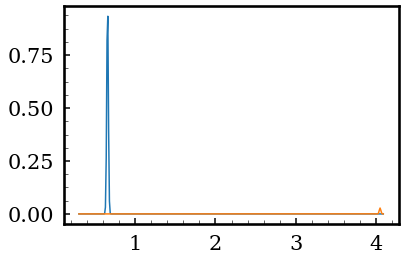

In [110]:
x = np.arange(0.3, 4.1, 0.01)

plt.figure()
plt.plot(x, g_Halpha(x))
plt.plot(x, g_Bralpha(x))

In [111]:
np.trapz(g_Bralpha(x), x)/np.trapz(g_Halpha(x), x)

0.027778099878436623

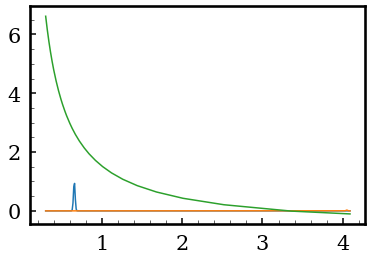

In [112]:
from scipy.interpolate import interp1d
f = interp1d(1/new_x, att_linear)
interp_x = x

plt.figure()
plt.plot(x, g_Halpha(x))
plt.plot(x, g_Bralpha(x))
plt.plot(interp_x, f(interp_x))

In [113]:
tau = np.array(f(interp_x))
att_Halpha = np.array(g_Halpha(x)) * (1-np.exp(-tau))/tau

0.0796768266889398


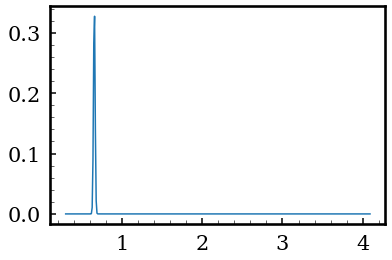

In [114]:
plt.figure()
plt.plot(interp_x, att_Halpha)

ratio = np.trapz(g_Bralpha(x), x)/np.trapz(att_Halpha, interp_x)
print(ratio)

Now we conclude that the ratio between Br alpha and the attenduated H alpha is 0.0449. 

In [102]:
ratio/0.02778

8.090722421699875

# IMF calculation. Derive the factor between Salpeter and Kroupa

#### Murphy et al. 2011 uses Kroupa IMF with slope -1.3 in 0.1-0.5 M_sun and slope -2.3 in 0.5-100 M_sun
#### Zhuang et al. 2019 uses Salpeter IMF with slope -2.35 in 1-100 M_sun

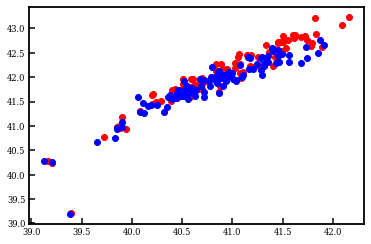

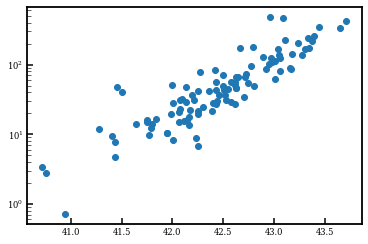

In [49]:
mode = 'mx'

plt.figure()
for mode, c in zip(['mx', 'oc'], ['r', 'b']):
    df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
    
    plt.plot(np.log10(df.L_Br_alpha + 0.02*df.S24), np.log10(df.L_f33), 'o', color=c)

mode = 'mx'
df = pd.read_pickle("/Users/thomaslai/Documents/astro/PAH/PAHFIT_akari/" + mode + "_SFR.pkl")
df['sf_PAH'] = 10**(-42.56 + np.log10((df.L_f62+df.L_f77+df.L_f113)))
plt.figure()
plt.plot(np.log10(df.L_Br_alpha*100/2.778 + 0.02*df.S24), df.sf_Halpha_S24 ,'o')
#plt.plot(df.sf_LIR, df.sf_PAH, 'o')
# plt.xscale('log')
plt.yscale('log')
#plt.plot(np.log10(df.L_Br_alpha*100/2.778 + 0.02*df.S24), np.log10(df.L_f62+df.L_f77+df.L_f113), 'o')

#plt.ylim(39,46)

In [22]:
df[df.L_f33 == df.L_f33.min()].irc_id

82    1420298
Name: irc_id, dtype: object

In [25]:
df.columns

Index(['Br_alpha_strength', 'Br_alpha_strength_unc', 'GOALS_target',
       'NeIII_strength', 'NeIII_strength_unc', 'NeII_strength',
       'NeII_strength_unc', 'akari_color', 'conti27', 'conti43', 'dfwhm12',
       'dfwhm6', 'f113', 'f113_unc', 'f17', 'f17_unc', 'f33', 'f33_fwhm',
       'f33_unc', 'f33ew', 'f34', 'f347', 'f347_fwhm', 'f347_unc', 'f34_fwhm',
       'f34_unc', 'f62', 'f62_unc', 'f62ew', 'f77', 'f77_unc', 'f83',
       'f83_unc', 'f86', 'f86_unc', 'fwhm_H2O', 'hot_grains', 'irc_id',
       'log_LIR', 'mirclass', 'pah62_eqw_err_ideos', 'pah62_eqw_ideos',
       'phase', 'snr_at33', 'target', 'tau_H2O', 'tau_Si', 'tau_Si_ideos',
       'tot_pah', 'tot_pah_unc', 'vsg', 'z', 'S24', 'S24_snr', 'S24_unc',
       'S24_color', 'L_f33', 'L_f34', 'L_f347', 'L_f62', 'L_f77', 'L_f83',
       'L_f86', 'L_f113', 'L_f17', 'L_tot_pah', 'L_NeII', 'L_NeII_unc',
       'L_NeIII', 'L_NeIII_unc', 'L_Br_alpha', 'L_Br_alpha_unc', 'L_S24',
       'L_S24_unc', 'L_IR', 'nsum', 'nsum_int', 'conti